In [68]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as sps
import seaborn as sns
sns.set(style='ticks', font_scale=1.3)

import scipy.optimize

rcParams['figure.figsize'] = 10, 5

from typing import Optional, Union, List, Tuple

In [2]:
import logging

logger = logging.getLogger(__name__)
loglevel = "DEBUG"
logger.setLevel(loglevel)
handler = logging.StreamHandler()
handler.setLevel(loglevel)
format = '%(levelname)s: %(message)s'
handler.setFormatter(logging.Formatter(format))
logger.addHandler(handler)

## Task 2: Gradient descent

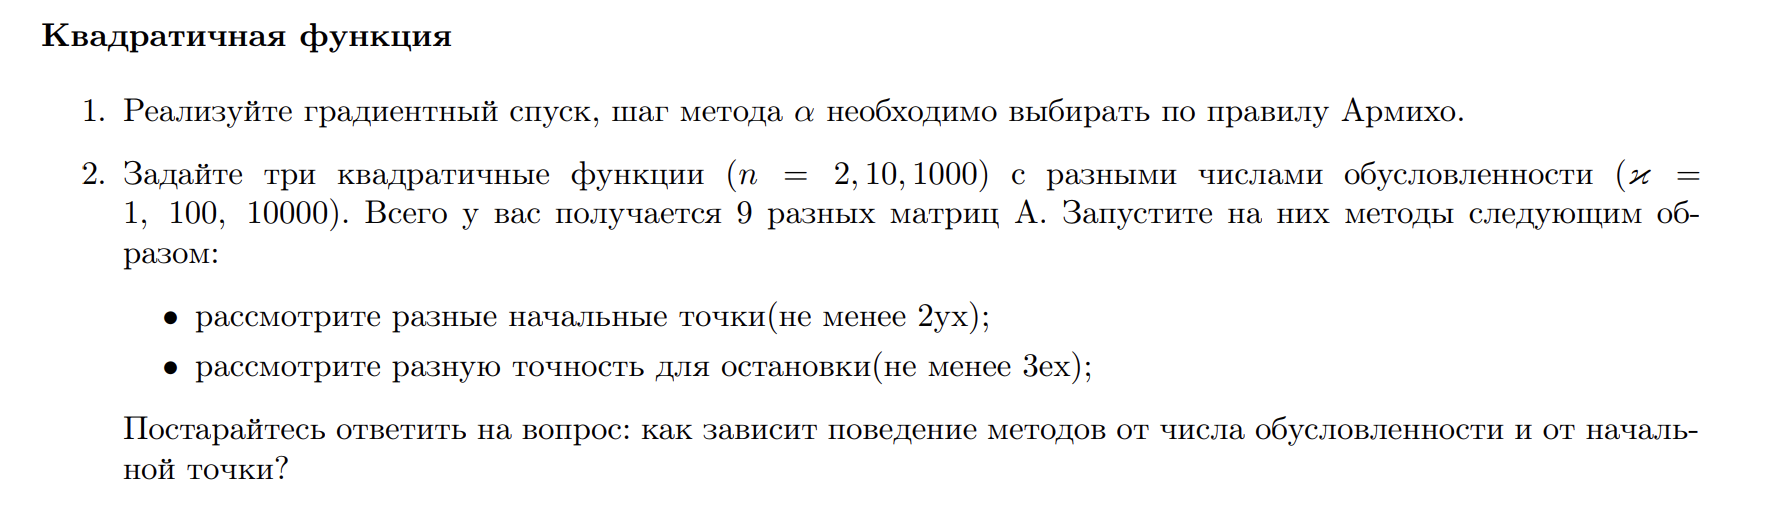

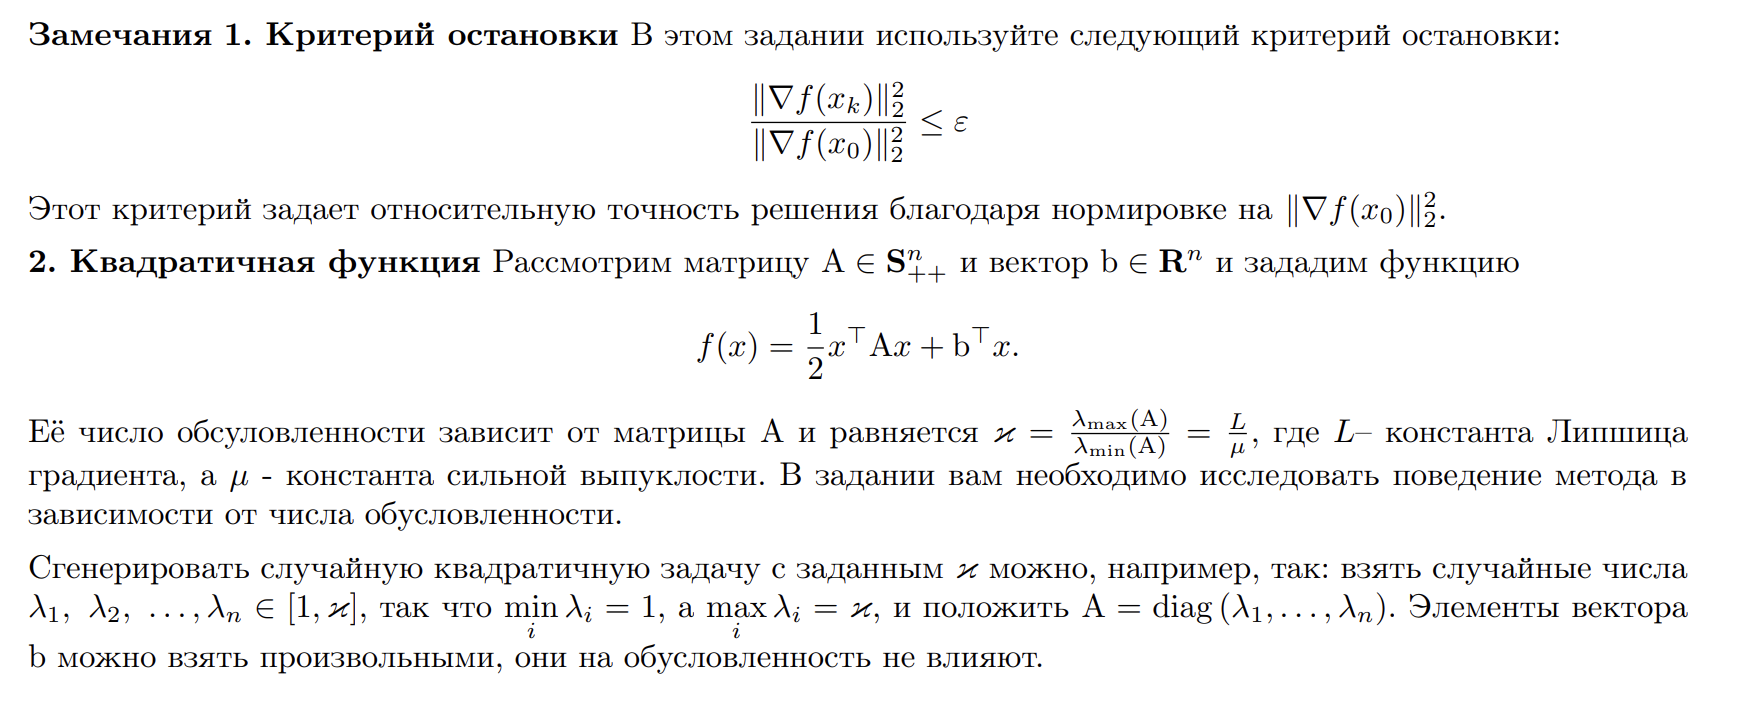

### Functions

In [67]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

In [124]:
def quadratic_func_params(n: int, cond_num: int) -> Tuple[np.ndarray, np.ndarray]:
    """ 
    Generate parameters for quadratic function f(x) = (1/2) * (x.T @ A @ x) + (b.T @ x)
    
    :param n: dimension of x
    :param cond_num: condition number of matrix A
    :return: A, b
    """
    lambdas = sps.uniform(loc=1, scale=cond_num).rvs(size=n)
    lambdas[np.argmin(lambdas)] = 1
    lambdas[np.argmax(lambdas)] = cond_num

    A = np.diagflat(lambdas)
    b = np.random.rand(n) * 5
    
    return A, b

In [133]:
def draw_convergence_plot(f_vals: np.ndarray, N_iterations: int, label: Optional[str] = None):

    plt.plot(np.arange(N_iterations), f_vals[:N_iterations], lw=3, label=label)

    plt.ylabel("Function value")
    plt.xlabel("Number of iteration")
    if label is not None: plt.legend()
    plt.grid()

In [134]:
def draw_alpha_plot(alphas: np.ndarray, N_iterations: int):
    
    plt.plot(np.arange(N_iterations), alphas[:N_iterations], lw=3)

    plt.ylabel("Step alpha")
    plt.xlabel("Number of iteration")
    plt.grid()

In [238]:
def gradient_descent(n: int, N: int, alpha: float, eps: float, 
                     A: np.ndarray, b: np.ndarray,
                     x0: Optional[np.ndarray] = None, 
                     verbose: bool = False):
    """
    Gradient method
    
    :param n: size of x
    :param N: maximim number of iterations
    :param alpha: initial gradient step
    :param eps: tolerance
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param x0: initial guess of x
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    if x0 is None:
        # x0 = (np.random.rand(n) + 10) * 5
        x0 = np.random.rand(n)
    
    x = np.zeros((N, n))
    x[0] = x0
    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], A, b)
    alphas = np.zeros(N)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    
    end_iteration = N
    
    for k in range(N-1): 
        
        h_k = grad_f(x[k], A, b)
        
        # Armijo rule
        while f(x[k] - alpha * h_k, A, b) > f(x[k], A, b) + 0.2 * alpha * (h_k @ h_k):
            alpha_new = alpha * 0.5
            logger.debug(f"iteration: {k}; Armijo condition is not true, change alpha from {alpha:.6f} to {alpha_new:.6f}")
            alpha = alpha_new
        
        alphas[k] = alpha
        
        # GD step
        x[k+1] = x[k] - alpha * h_k
                
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        if stop_criteria:
            end_iteration = k+1
            logger.info(f'GD converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x[k+1]}')
            break


    if not stop_criteria:
        logger.info(f'(!) GD didnt converge, may be need to increase number of iterations N')
        logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
        
        
    return f_vals, x, end_iteration, alphas

Пример: градиентный спуск

Задаем матрицу А и столбец b в функции f(x)

In [239]:
n = 2
cond_num = 100

A, b = quadratic_func_params(n, cond_num)
A, b

(array([[  1.,   0.],
        [  0., 100.]]),
 array([1.00240793, 1.04760869]))

Запускаем град спуск

In [241]:
N = int(1e5)
alpha = 2
eps = 1e-10
x0 = np.random.rand(n)*5 + 10

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 2.000000 to 1.000000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 1.000000 to 0.500000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.500000 to 0.250000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.250000 to 0.125000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.125000 to 0.062500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.062500 to 0.031250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.031250 to 0.015625
INFO: GD converge at 455 iteration, min f(x) = -0.5078285443735873
DEBUG: x_min = [-0.99060042 -0.01047609]


Сравним результат со scipy

In [242]:
scipy.optimize.minimize(f, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.5078982530574415
        x: [-1.002e+00 -1.048e-02]
      nit: 3
      jac: [ 3.651e-07 -8.121e-07]
 hess_inv: [[ 1.000e+00 -3.269e-06]
            [-3.269e-06  1.000e-02]]
     nfev: 15
     njev: 5

Посмотрим на график сходимости метода

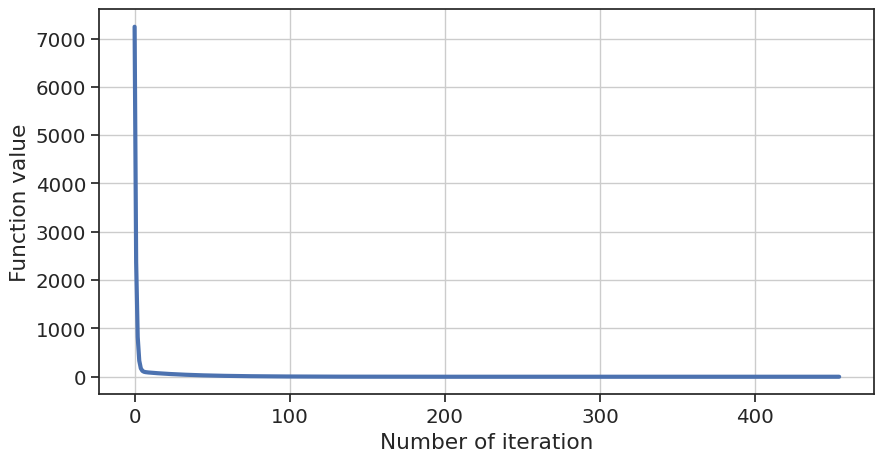

In [243]:
draw_convergence_plot(f_vals, N_iterations)

### Генерация 9 матриц с разными числами обусловленности

In [244]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.932498674484581


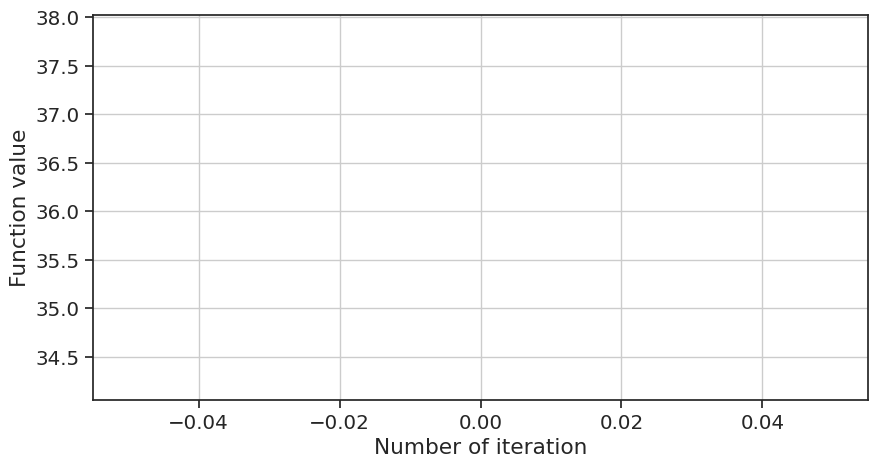

INFO: n = 2, condition number = 100
INFO: GD converge at 444 iteration, min f(x) = -5.780799049306638


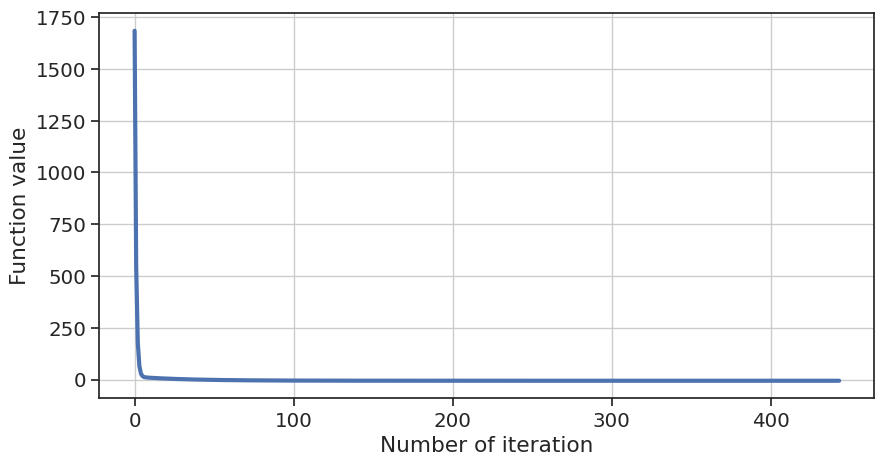

INFO: n = 2, condition number = 1000
INFO: GD converge at 2885 iteration, min f(x) = -2.6995453767435995


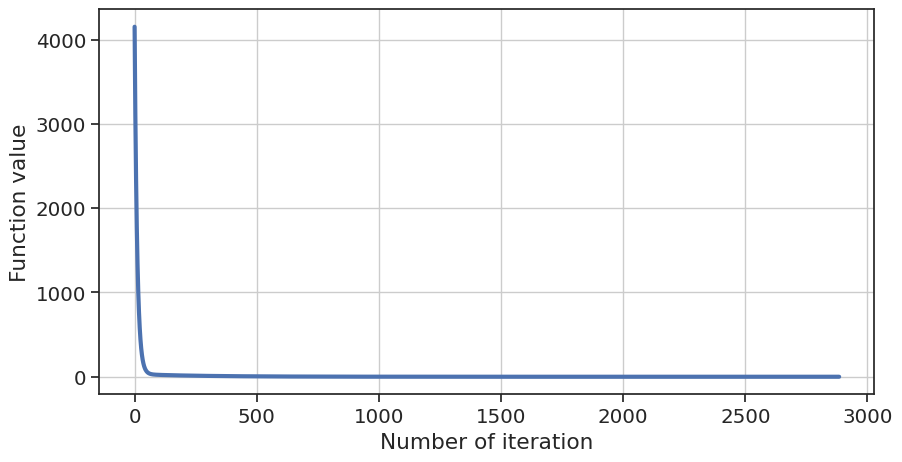

INFO: n = 10, condition number = 1
INFO: GD converge at 32 iteration, min f(x) = -32.07836304184955


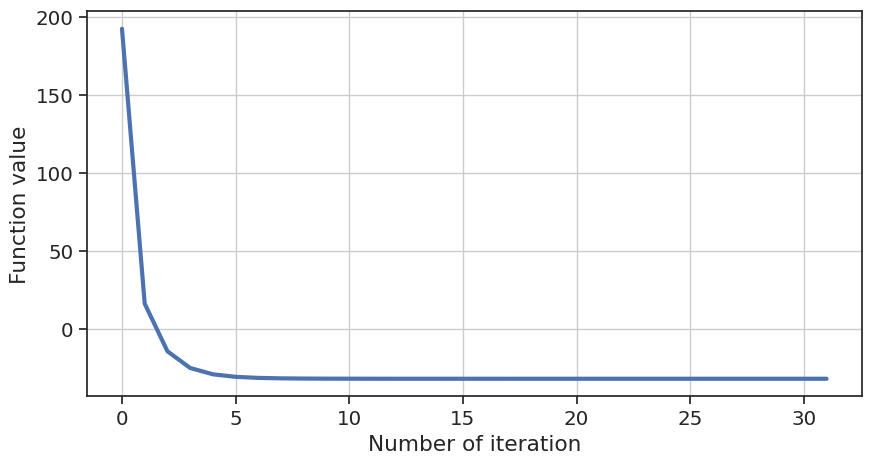

INFO: n = 10, condition number = 100
INFO: GD converge at 439 iteration, min f(x) = -6.066193493721759


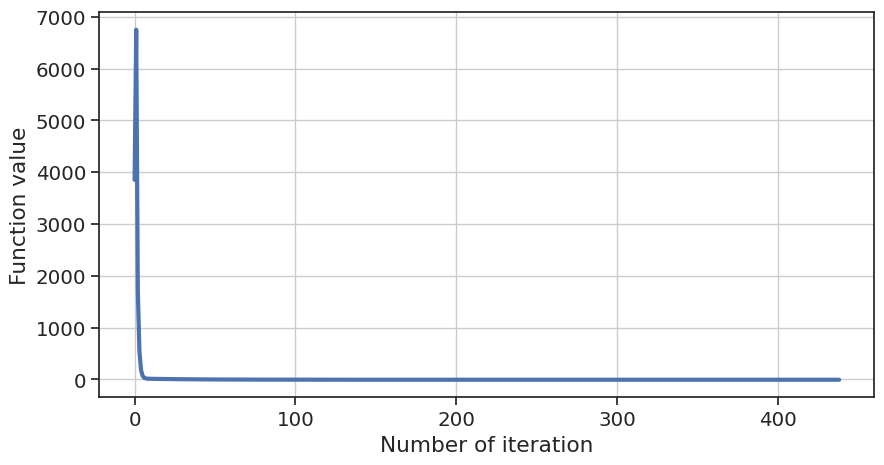

INFO: n = 10, condition number = 1000
INFO: GD converge at 2179 iteration, min f(x) = -1.5057391916602885


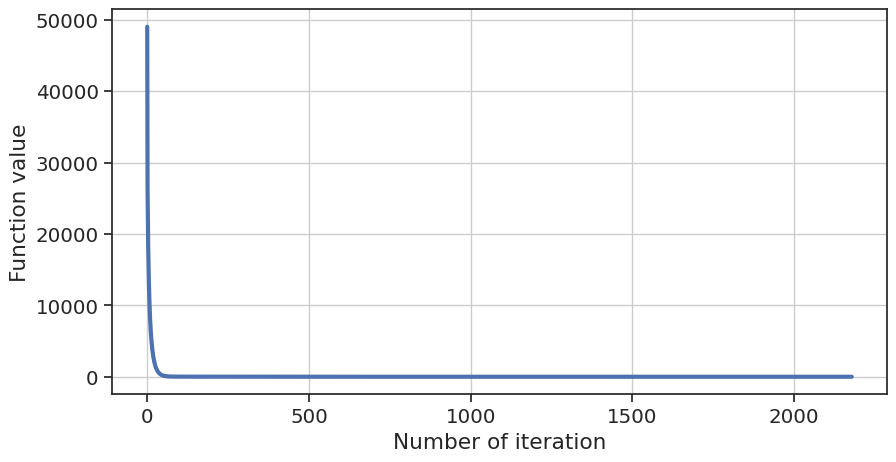

INFO: n = 1000, condition number = 1
INFO: GD converge at 2188 iteration, min f(x) = -2988.693552747678


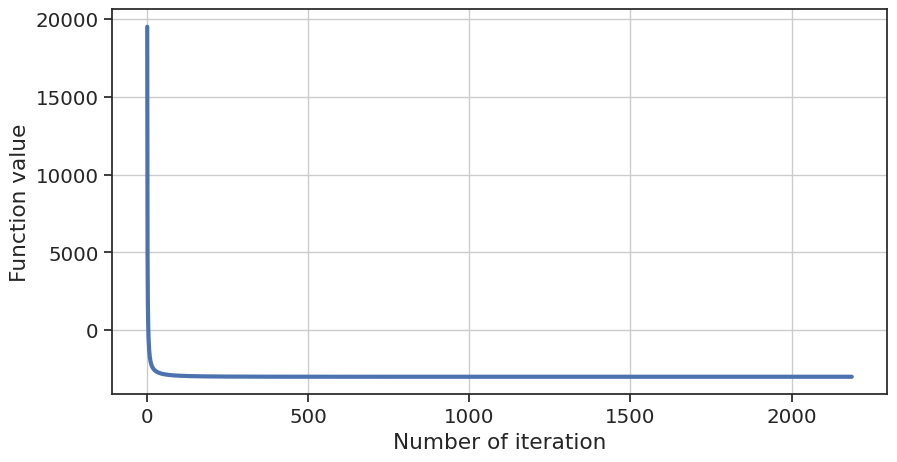

INFO: n = 1000, condition number = 100
INFO: GD converge at 278 iteration, min f(x) = -207.96836594129184


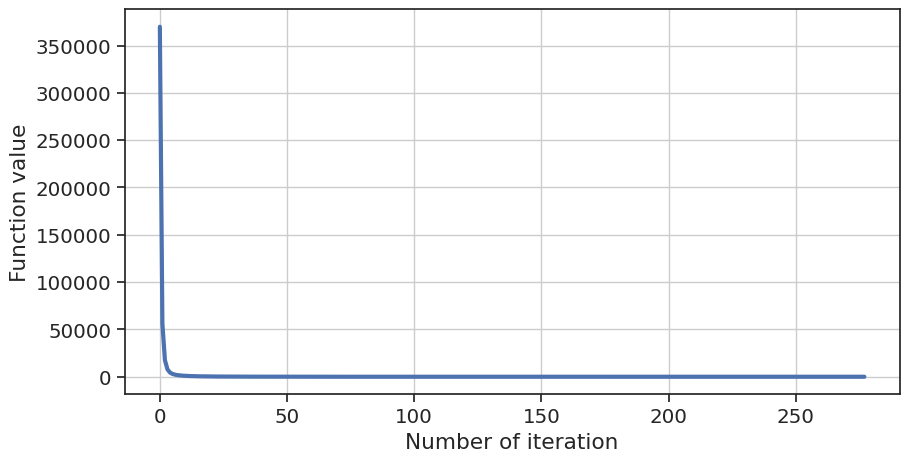

INFO: n = 1000, condition number = 1000
INFO: GD converge at 1125 iteration, min f(x) = -37.425989500597446


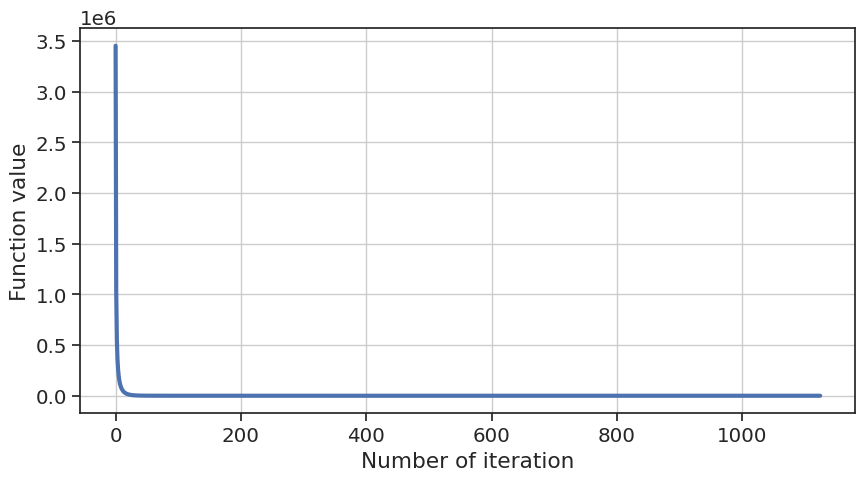

In [258]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
    
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.9324986744845813


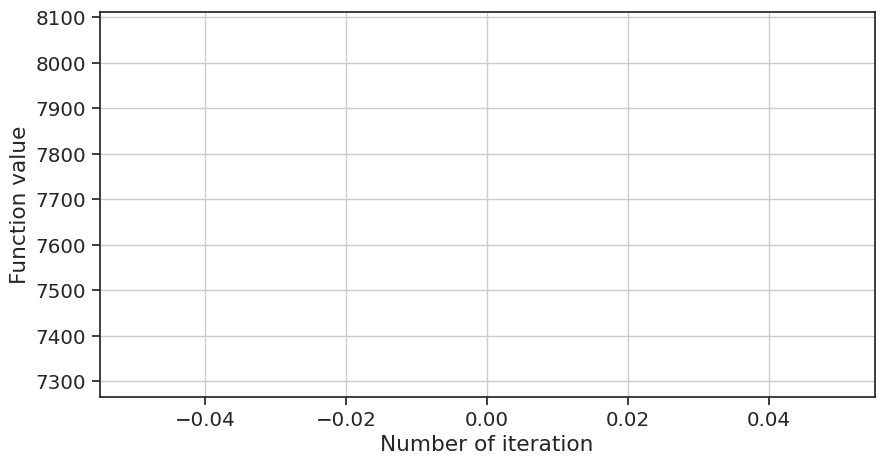

INFO: n = 2, condition number = 100
INFO: GD converge at 409 iteration, min f(x) = -5.775423600402708


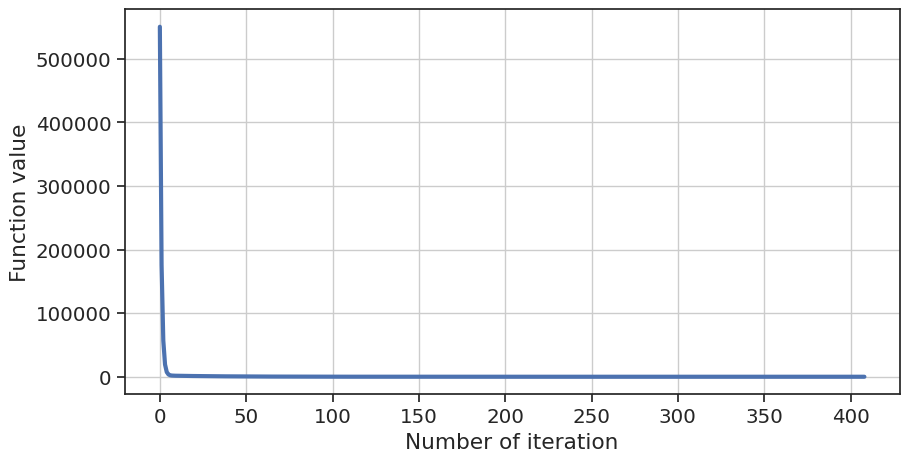

INFO: n = 2, condition number = 1000
INFO: GD converge at 2637 iteration, min f(x) = -2.509431355995832


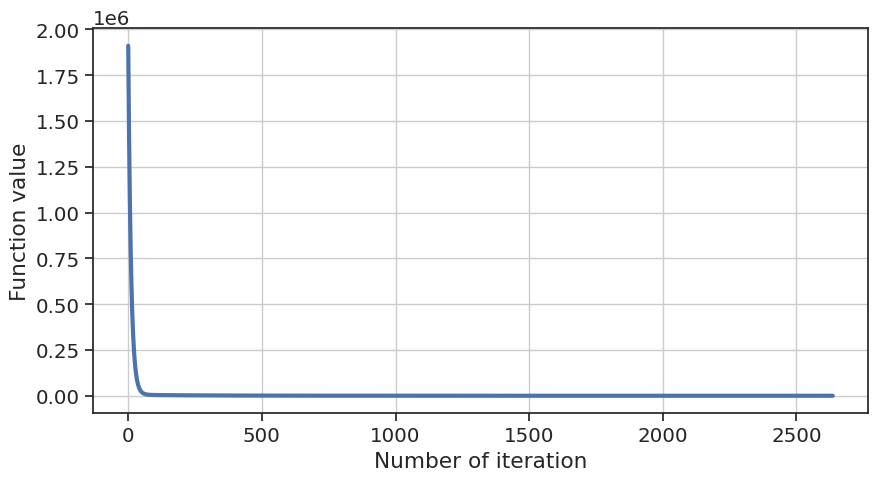

INFO: n = 10, condition number = 1
INFO: GD converge at 33 iteration, min f(x) = -32.07836151631011


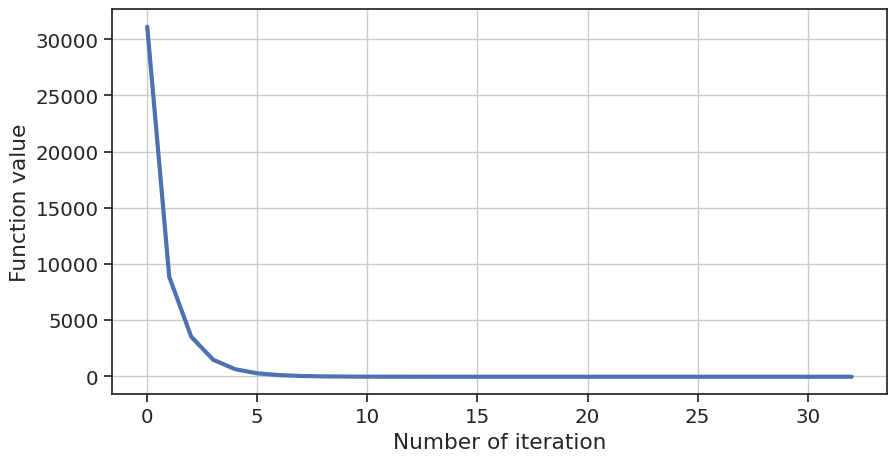

INFO: n = 10, condition number = 100
INFO: GD converge at 403 iteration, min f(x) = -6.0575759247964935


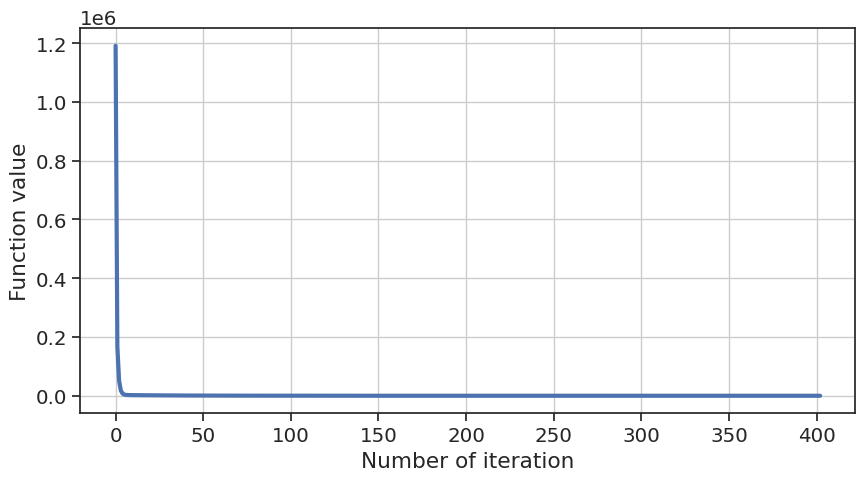

INFO: n = 10, condition number = 1000
INFO: GD converge at 2104 iteration, min f(x) = -0.4690868403426252


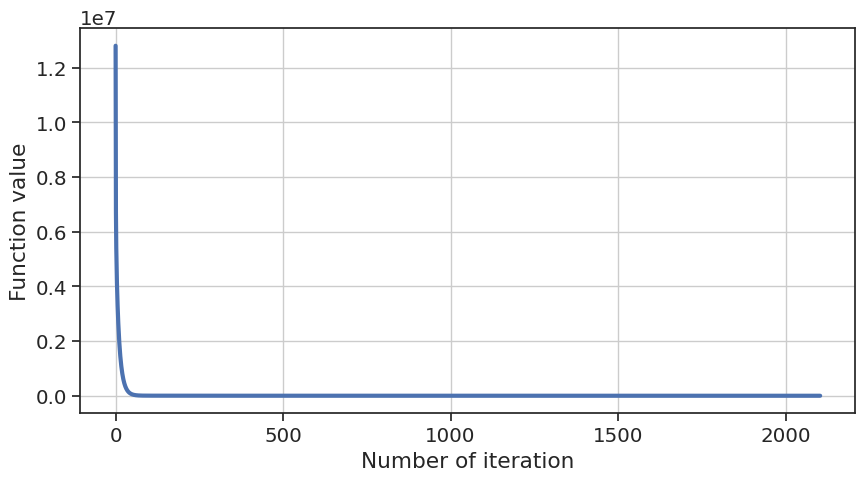

INFO: n = 1000, condition number = 1
INFO: GD converge at 2159 iteration, min f(x) = -2988.6933012082527


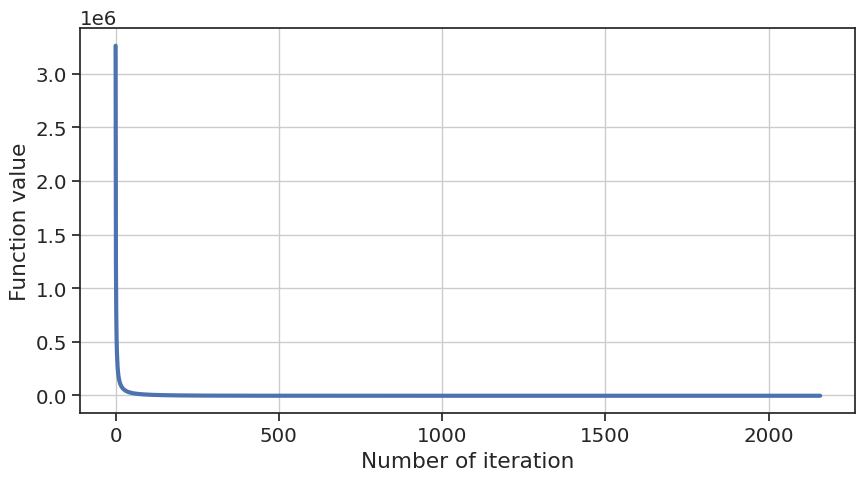

INFO: n = 1000, condition number = 100
INFO: GD converge at 278 iteration, min f(x) = -207.36551190902702


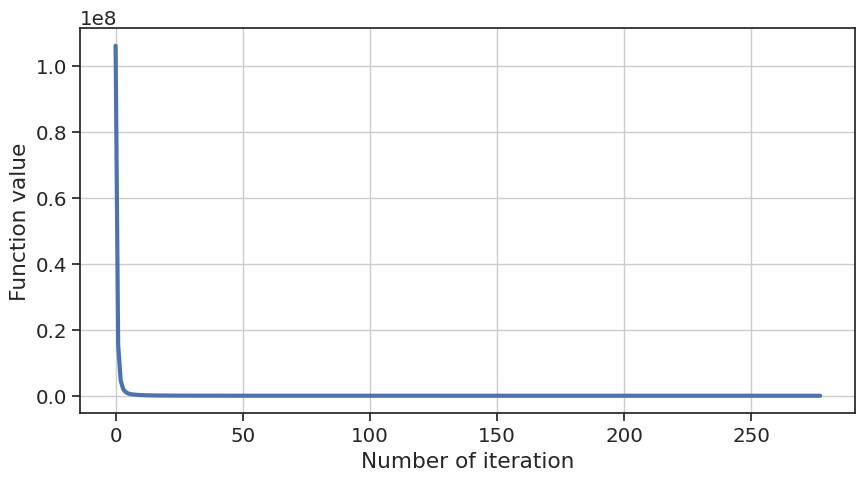

INFO: n = 1000, condition number = 1000
INFO: GD converge at 659 iteration, min f(x) = -2.307771946393075


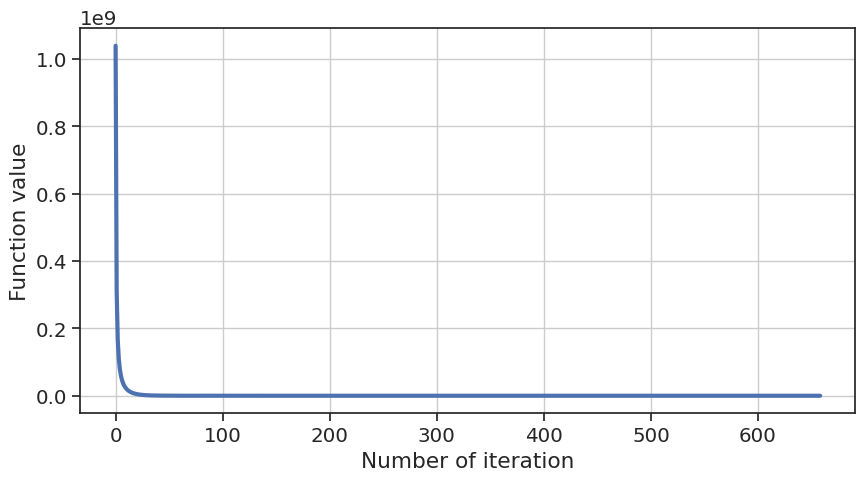

In [259]:
N = int(1e4)
eps = 1e-10


for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=23)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.932498674484581


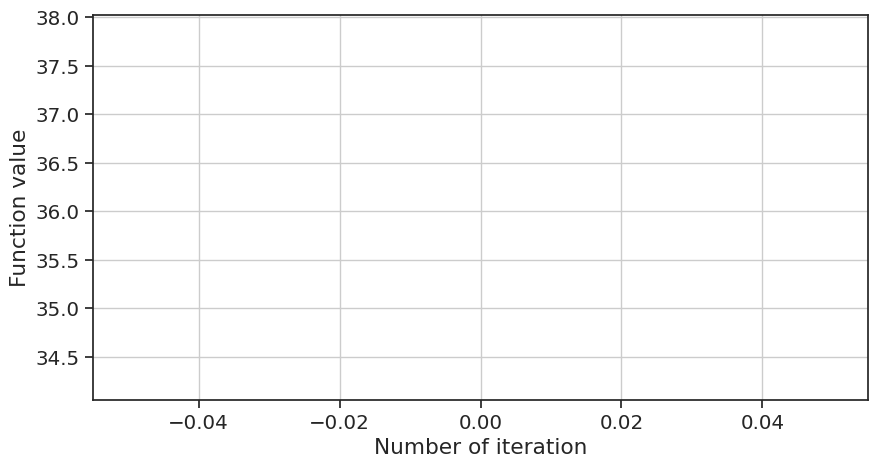

INFO: n = 2, condition number = 100
INFO: GD converge at 79 iteration, min f(x) = -4.151868745184153


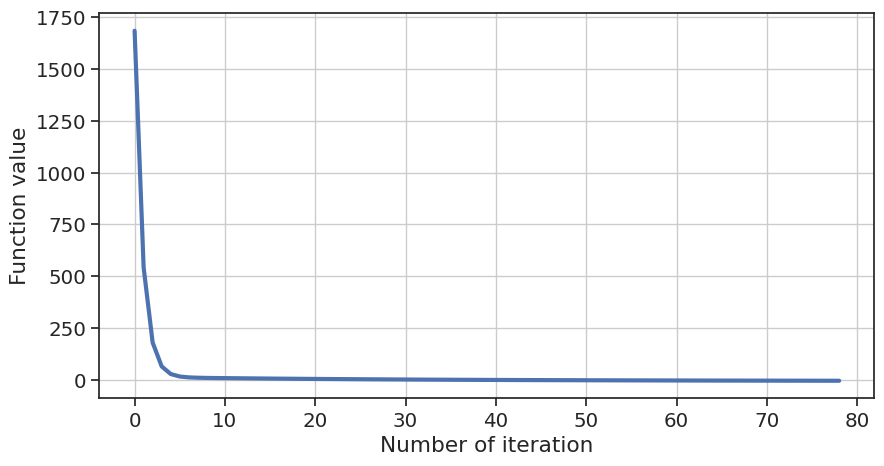

INFO: n = 2, condition number = 1000
INFO: GD converge at 127 iteration, min f(x) = 17.174806624738775


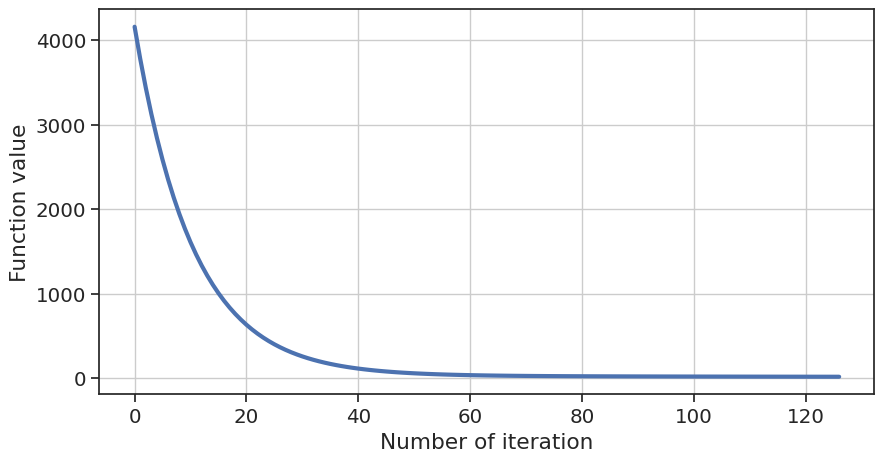

INFO: n = 10, condition number = 1
INFO: GD converge at 14 iteration, min f(x) = -32.07663021208579


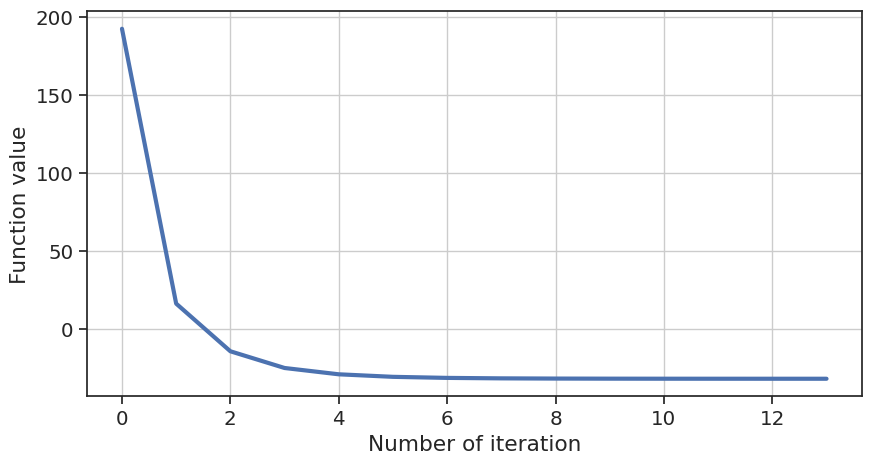

INFO: n = 10, condition number = 100
INFO: GD converge at 74 iteration, min f(x) = -3.6182680718471953


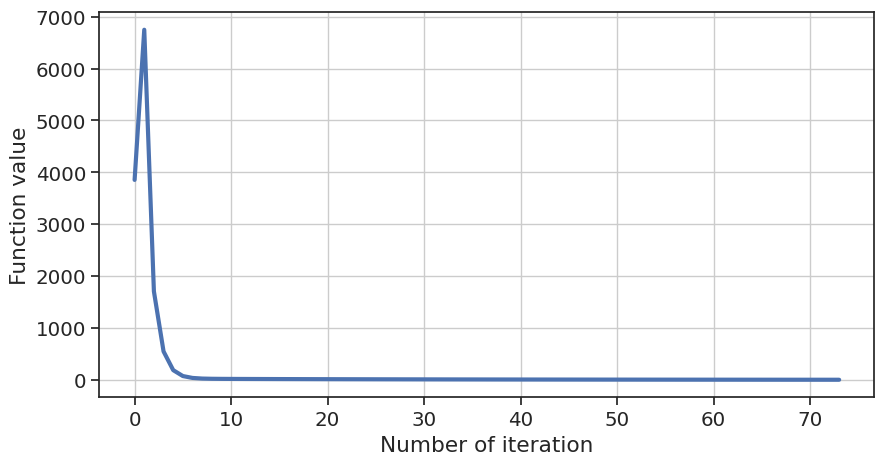

INFO: n = 10, condition number = 1000
INFO: GD converge at 112 iteration, min f(x) = 11.81223445529006


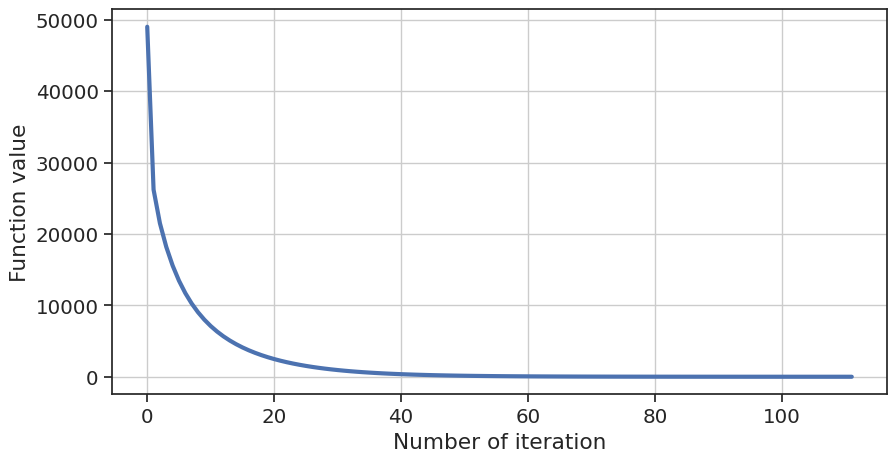

INFO: n = 1000, condition number = 1
INFO: GD converge at 708 iteration, min f(x) = -2988.523499525881


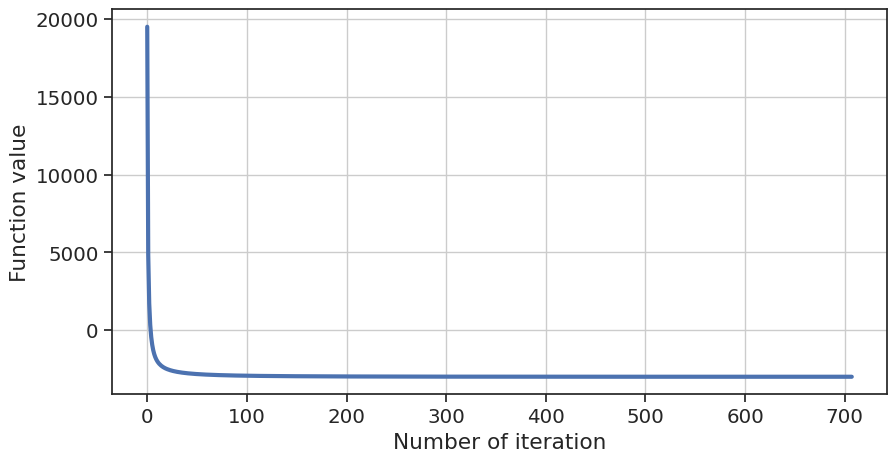

INFO: n = 1000, condition number = 100
INFO: GD converge at 32 iteration, min f(x) = -92.34955775162643


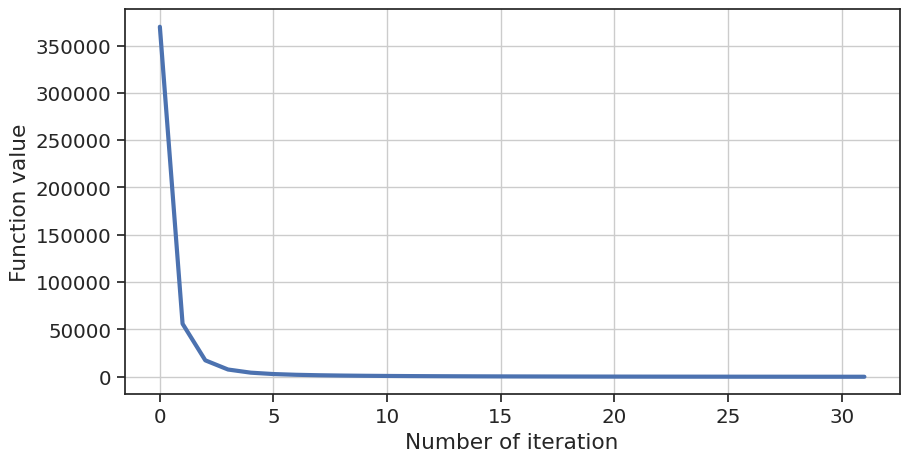

INFO: n = 1000, condition number = 1000
INFO: GD converge at 76 iteration, min f(x) = 147.3748692621096


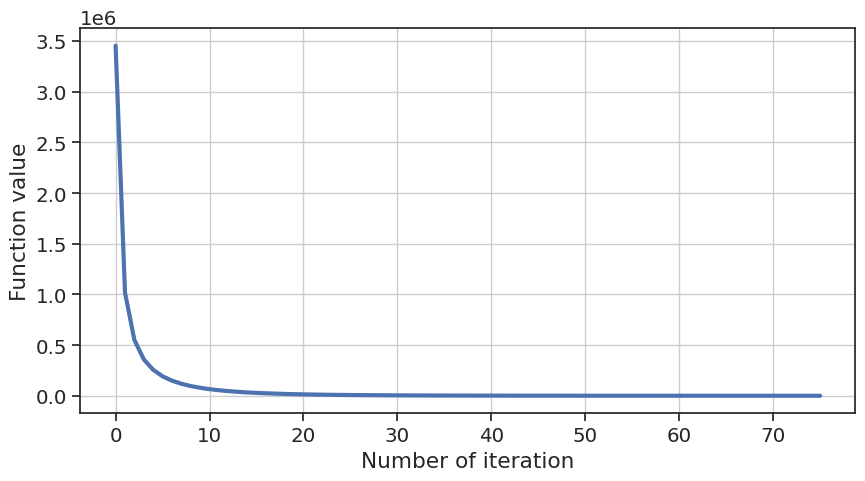

In [255]:
N = int(1e4)
eps = 1e-5

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.932498674484581


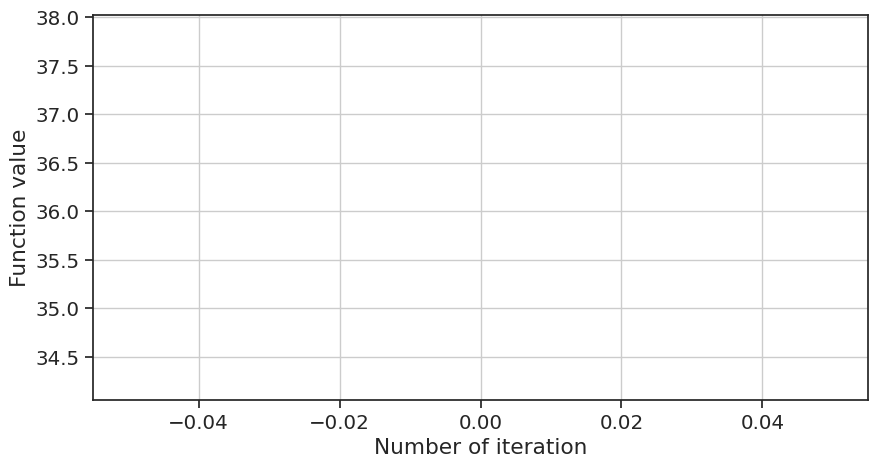

INFO: n = 2, condition number = 100
INFO: GD converge at 298 iteration, min f(x) = -5.779170335047158


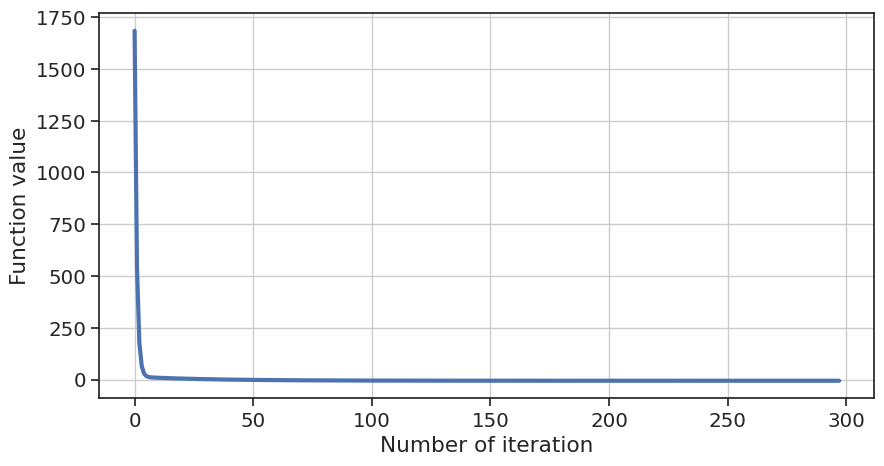

INFO: n = 2, condition number = 1000
INFO: GD converge at 1707 iteration, min f(x) = -2.658764887710257


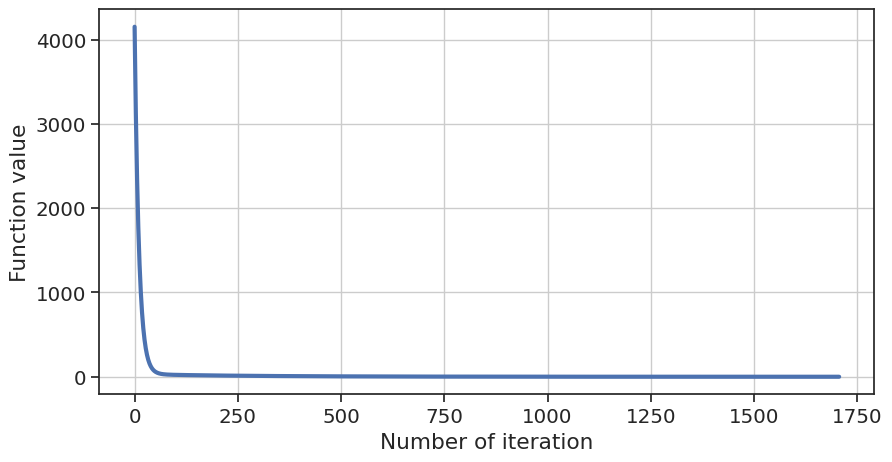

INFO: n = 10, condition number = 1
INFO: GD converge at 25 iteration, min f(x) = -32.07836199415121


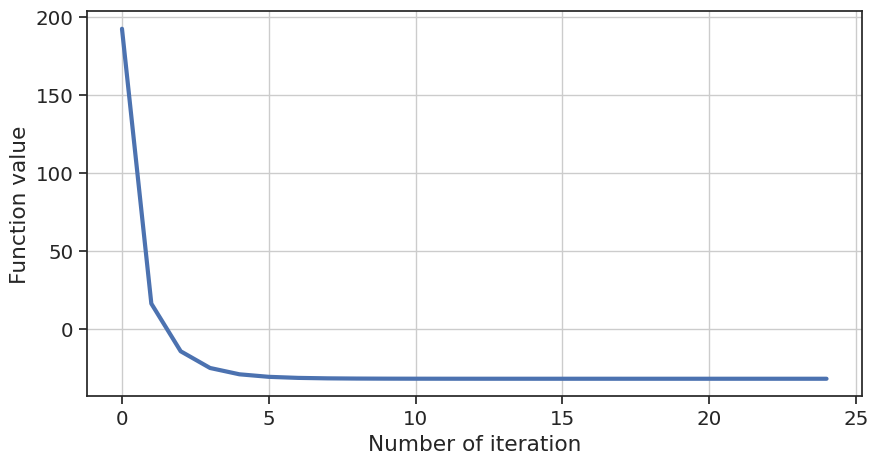

INFO: n = 10, condition number = 100
INFO: GD converge at 293 iteration, min f(x) = -6.063745892967659


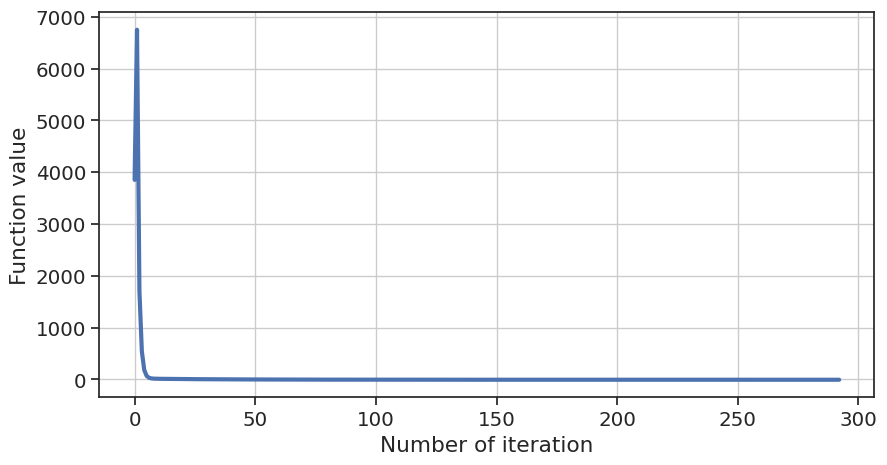

INFO: n = 10, condition number = 1000
INFO: GD converge at 1001 iteration, min f(x) = -1.108659955446536


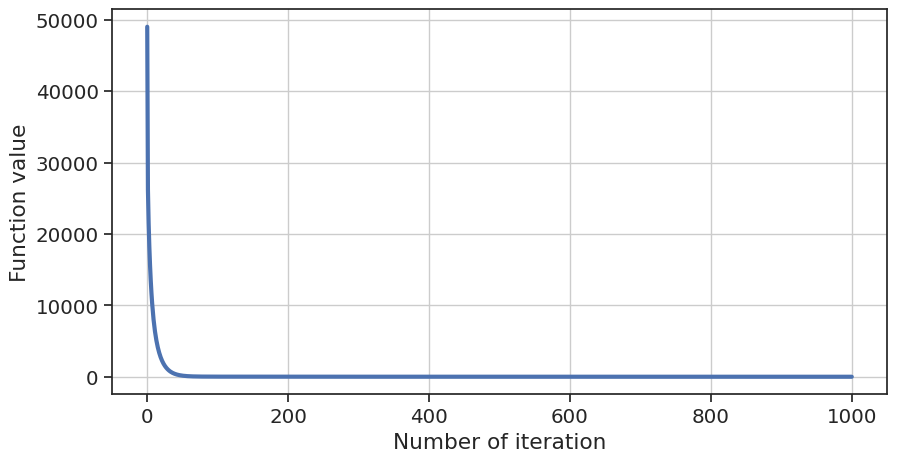

INFO: n = 1000, condition number = 1
INFO: GD converge at 1582 iteration, min f(x) = -2988.6933837466777


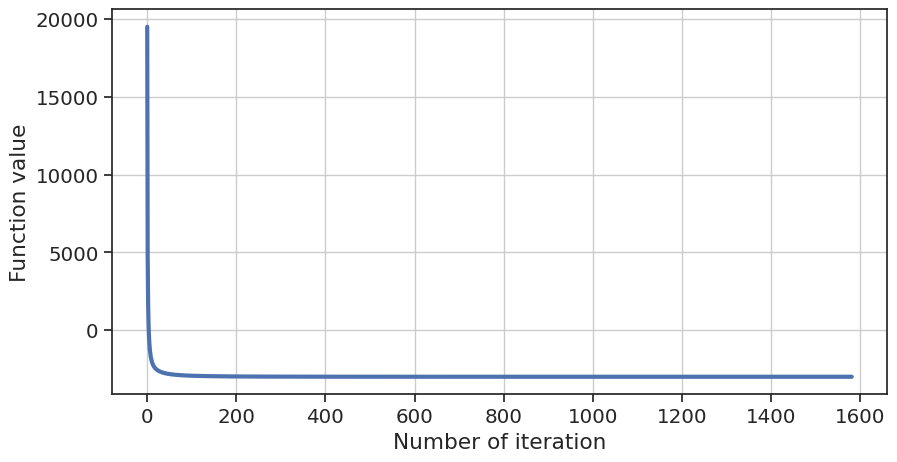

INFO: n = 1000, condition number = 100
INFO: GD converge at 164 iteration, min f(x) = -207.7822631498413


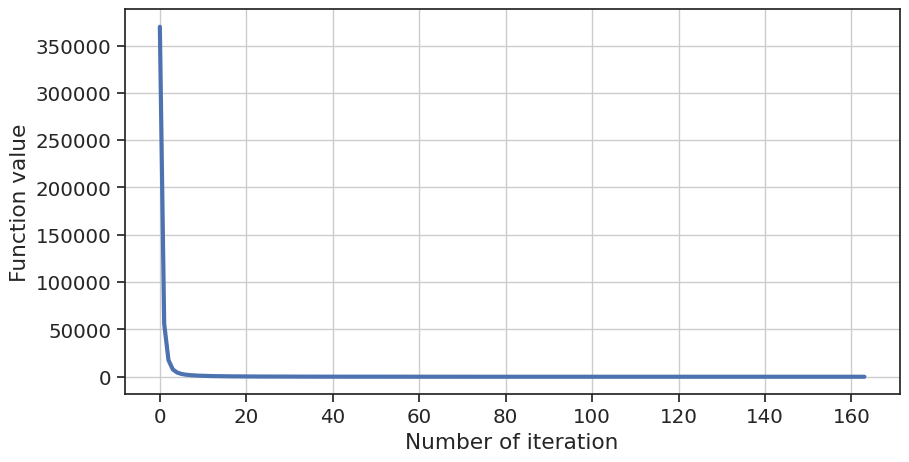

INFO: n = 1000, condition number = 1000
INFO: GD converge at 302 iteration, min f(x) = -25.613458621469192


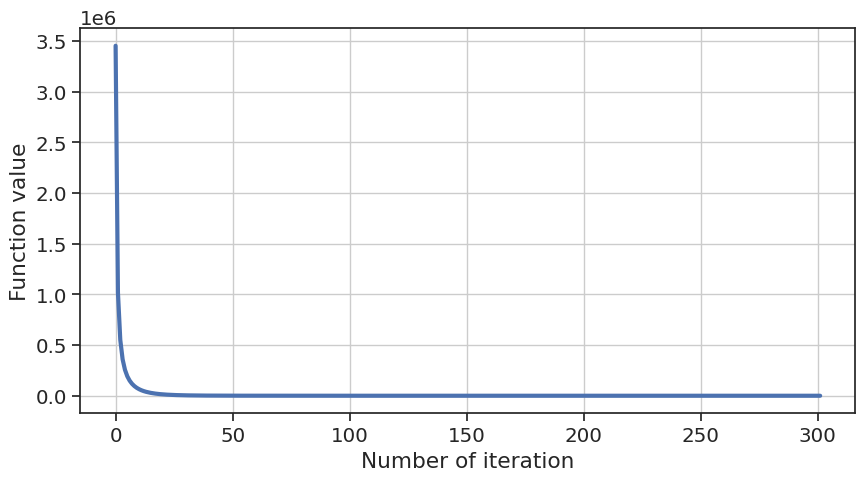

In [256]:
N = int(1e4)
eps = 1e-8

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: GD converge at 1 iteration, min f(x) = -3.932498674484581


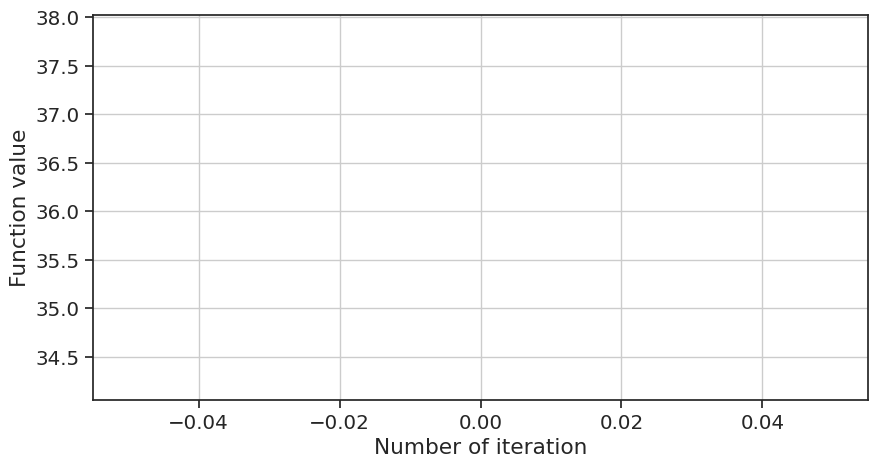

INFO: n = 2, condition number = 100
INFO: GD converge at 590 iteration, min f(x) = -5.78081544511886


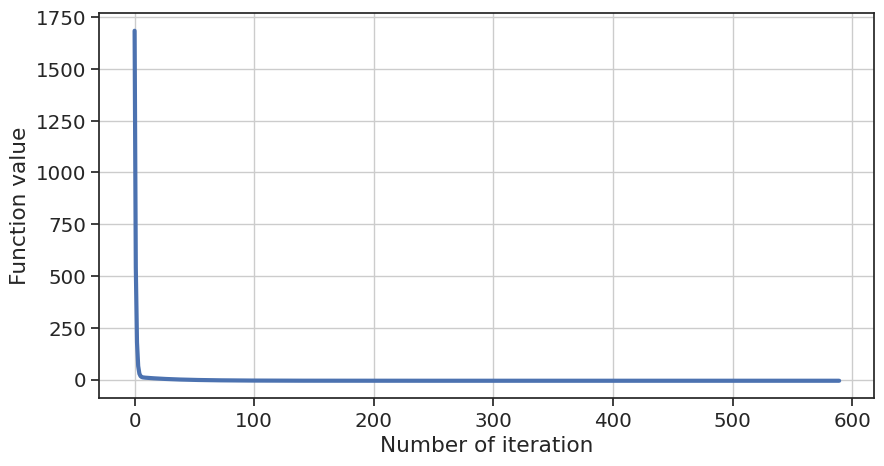

INFO: n = 2, condition number = 1000
INFO: GD converge at 4063 iteration, min f(x) = -2.699952818080134


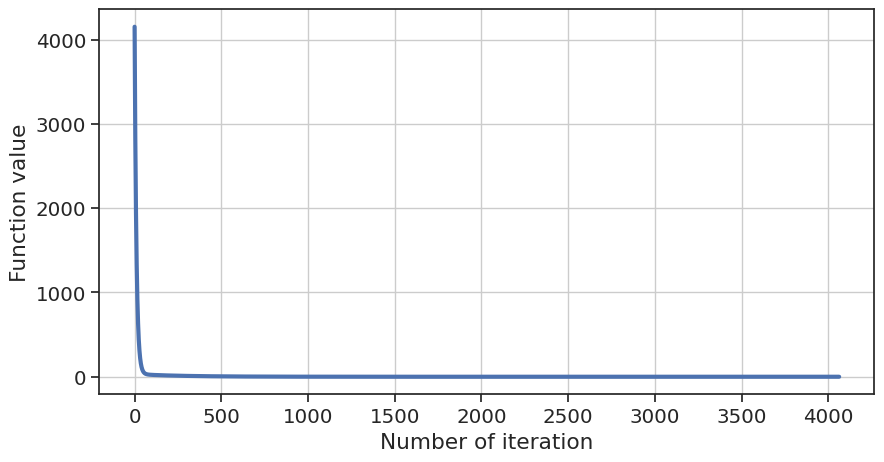

INFO: n = 10, condition number = 1
INFO: GD converge at 38 iteration, min f(x) = -32.07836305151264


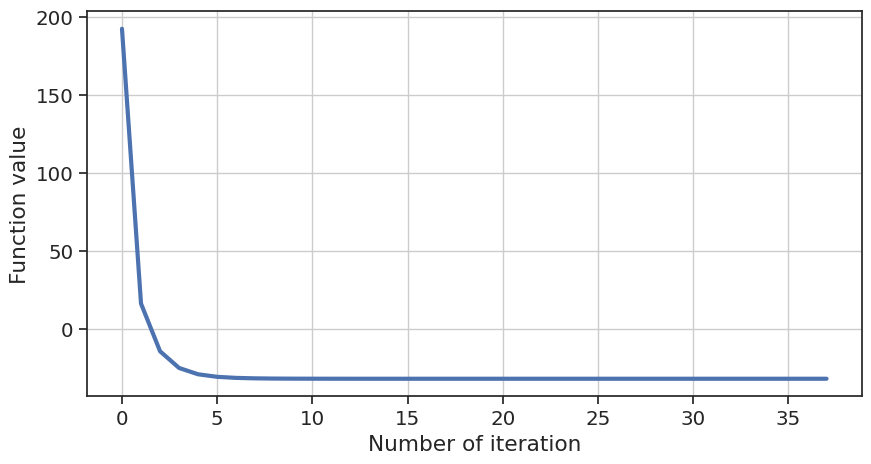

INFO: n = 10, condition number = 100
INFO: GD converge at 585 iteration, min f(x) = -6.066218133035948


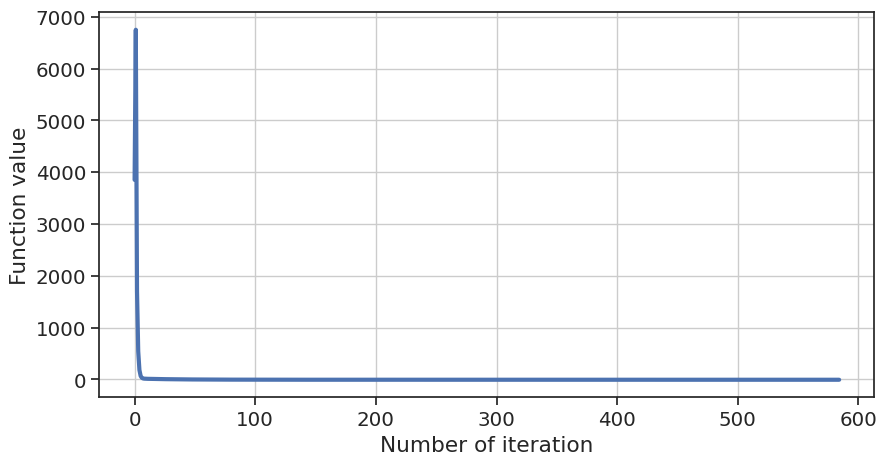

INFO: n = 10, condition number = 1000
INFO: GD converge at 3357 iteration, min f(x) = -1.5097064441025243


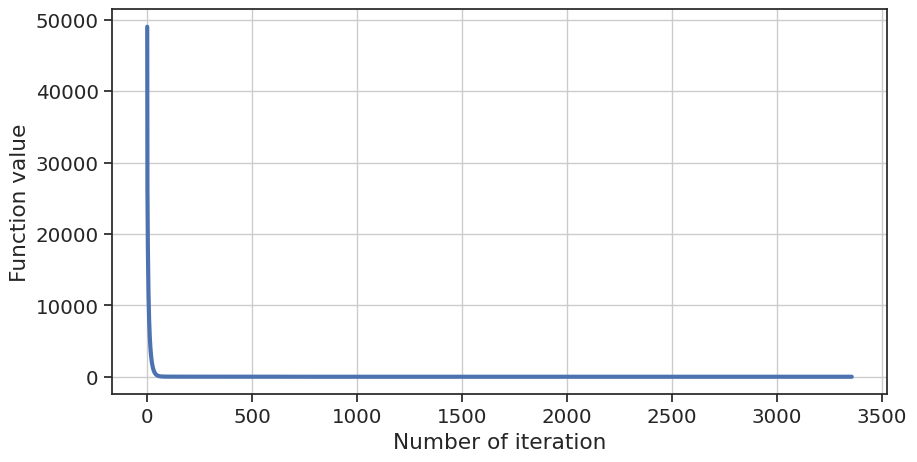

INFO: n = 1000, condition number = 1
INFO: GD converge at 2796 iteration, min f(x) = -2988.6935544327384


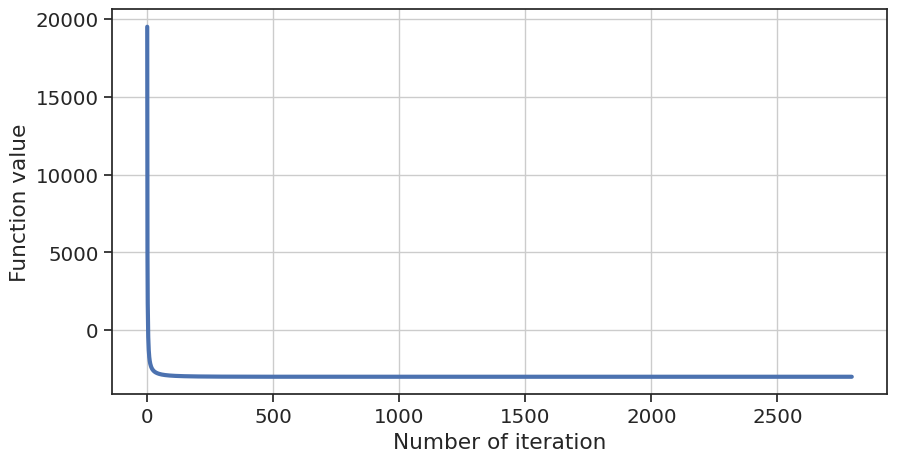

INFO: n = 1000, condition number = 100
INFO: GD converge at 407 iteration, min f(x) = -207.9704580663773


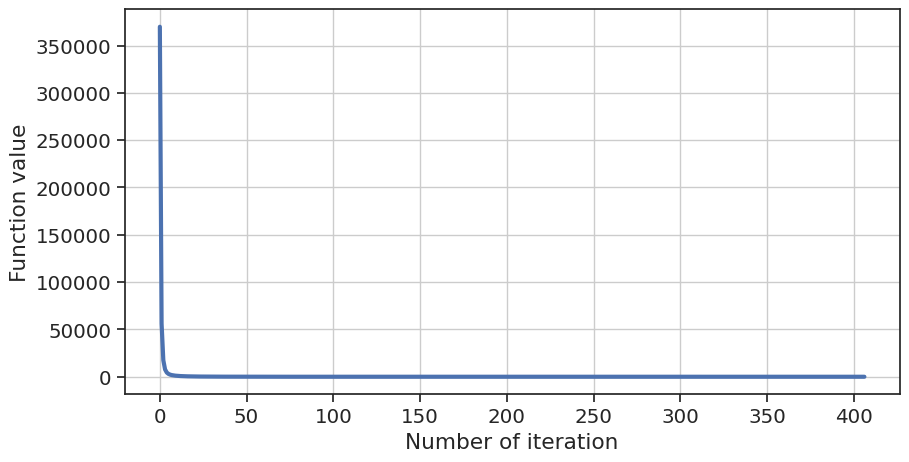

INFO: n = 1000, condition number = 1000
INFO: GD converge at 2289 iteration, min f(x) = -37.643354636408795


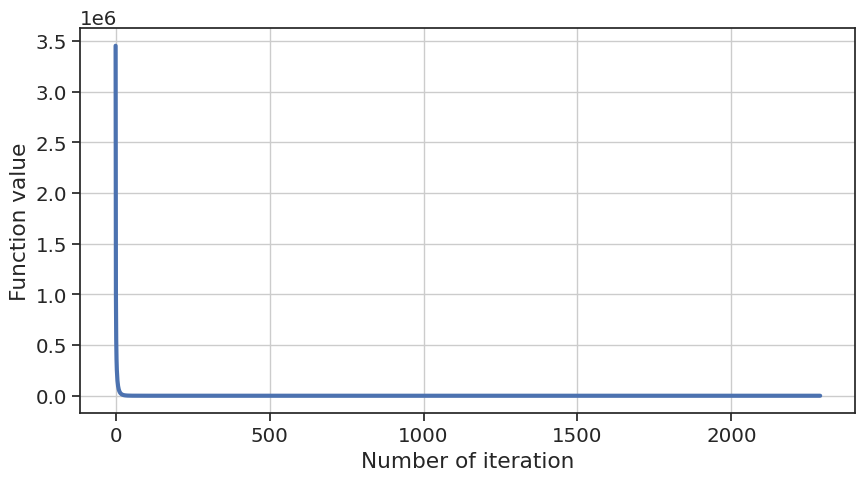

In [388]:
N = int(1e4)
eps = 1e-12

for A, b in zip(A_list, b_list):
    
    alpha = 1
        
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals, x, end_iteration, alphas = gradient_descent(n, N, alpha, eps, A, b, x0=x0, verbose=False)
        
    # logger.info(f"scipy ans = {scipy.optimize.minimize(f, x0, args=(A, b))['fun']}")
    
    draw_convergence_plot(f_vals, end_iteration)
    plt.show()

**Как зависит поведение методов от числа обусловленности и от начальной точки?**

Число итераций градиентного спуска, необходимых для достижения заданной точки увеличивается с ростом числа обусловленности.

При небольших числах обусловленности мградиентный спуск почти не зависит от начальной точки. 

Для числа обусловленности 1000 градиентный спуск, запущенный при разных начальных точках может давать разные результаты. Чтобы этого избежать, можно попробовать повысить требуемую точность (т. е. уменьзить значение `eps`)


Чем меньше значение точности `eps`, тем больше итераций требуется для ее достижения, но ответ получается точнее.

## Task 3: Rosenbrock function

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

$$ x^0 = (1.2, ~ 1.2), ~ x^0 = (-1.2, ~ 1) $$

1. Аналитически найдите точку минимума.
2. Исследуйте зависимость сходимости градиентного спуска от начального приближения, шаг метода выбирать по правилу Армихо. Необходимо рассмотреть как минимум 2 разные начальные точки $x_0$ и и 3 разные точности $\varepsilon$.
3. Постройте график зависимости длины шага от итерации для каждой начальной точки. Какой вывод Вы можете сделать?



---

Функция Розенброка:
$$ f(x_1, x_2) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

Найдем точку минимума:
$$ \frac{\partial f}{\partial x_1} = - 400 x_1 (x_2 - x_1^2) + 2(x_1 - 1)  = 0 \quad \quad (1)
$$
$$ \frac{\partial f}{\partial x_2} = 200 (x_2 - x_1^2) = 0 \quad \quad (2) $$

$$ (2) \Rightarrow (x_2 - x_1^2) = 0 \rightarrow (1) \rightarrow x_1 - 1 = 0$$

$$x_1 = 1 \rightarrow (1) \Rightarrow x_2 = 1$$

**Минимум функции**:
$$ (x_1^*, x_2^*) = (1, 1); \quad f(x_1^*, x_2^*) = 0 $$


---

In [260]:
def f(x, A, b):
    """Rosenbrock function"""
    x1, x2 = x
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

def grad_f(x, A, b):
    """Gradient of Rosenbrock function f(x1, x2)"""
    x1, x2 = x
    grad_x = -400 * x1 * (x2 - x1**2) + 2 * (x1 - 1)
    grad_y = 200 * (x2 - x1**2)
    
    return np.array([grad_x, grad_y])


1) Начальная точка $ x^0 = (1.2, ~ 1.2)$

In [261]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.003516 to 0.001758
INFO: GD converge at 2065 iteration, min f(x) = 0.0002004877501869588
DEBUG: x_min = [1.01414824 1.02855278]


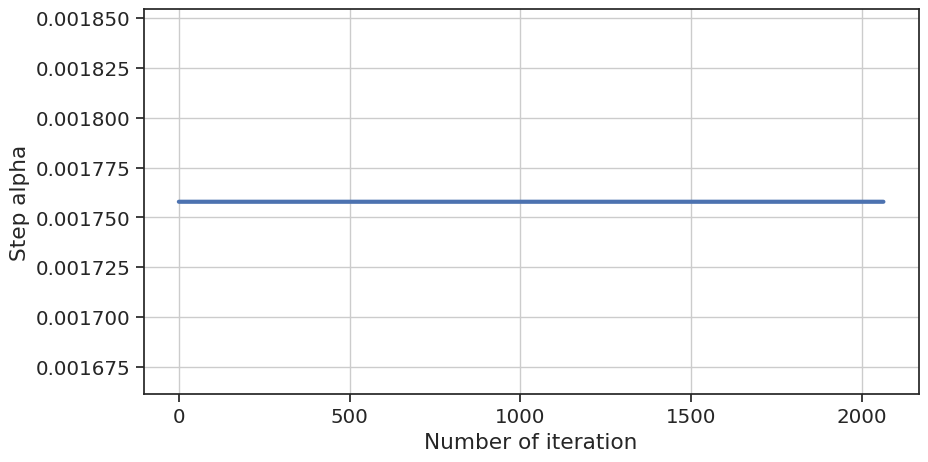

In [262]:
draw_alpha_plot(alphas, N_iterations)

2) Начальная точка $ x^0 = (-1.2, ~ 1)$

In [263]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([-1.2, 1])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=True)

DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.900000 to 0.450000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.450000 to 0.225000
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.225000 to 0.112500
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.112500 to 0.056250
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.056250 to 0.028125
DEBUG: iteration: 0; Armijo condition is not true, change alpha from 0.028125 to 0.014063
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.014063 to 0.007031
DEBUG: iteration: 1; Armijo condition is not true, change alpha from 0.007031 to 0.003516
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.003516 to 0.001758
DEBUG: iteration: 2; Armijo condition is not true, change alpha from 0.001758 to 0.000879
INFO: GD converge at 9145 iteration, min f(x) = 0.0006513648687563363
DEBUG: x_min = [0.97449919 0.9

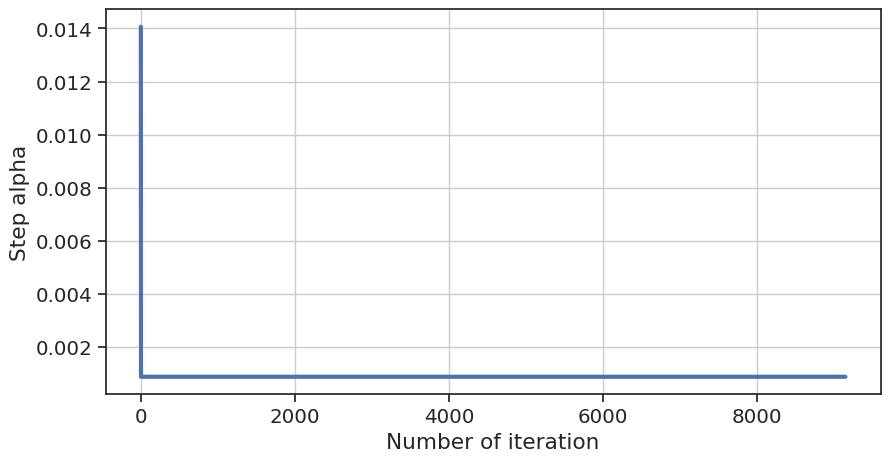

In [264]:
draw_alpha_plot(alphas, N_iterations)

**Вывод:** 

Видим, что в данном случае число итераций необходимых для сходимости может вырасти в 3 раза при неудачном начальном приближении.

Правило Армихо корректирует длину шага `alpha` на первых итерациях, после чего она не меняется до конца обучения.

Это помогает методу не разойтись в случае когда мы задали слишком большое `alpha`, но в то же время такое сильное уменьшение шага приводит к увеличению числа итераций, необходимых для достижения заданной точности.

3) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-5}$

In [267]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-5
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 79 iteration, min f(x) = 0.0029325730519402147


4) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-8}$

In [268]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-8
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 2065 iteration, min f(x) = 0.0002004877501869588


5) Начальная точка $ x^0 = (1.2, ~ 1.2)$, точность eps = $10^{-12}$

In [269]:
n = 2
N = int(1e6)
alpha = 0.9
eps = 1e-12
x0 = np.array([1.2, 1.2])

f_vals, x, N_iterations, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 8671 iteration, min f(x) = 1.959678667215104e-08


При увеличнии точности (понижении `eps`), число итераций растет, но ответ становится все ближе к аналитическому

## Task 4.2: Conjugate gradient method

Для функции:

$$ f(x) = x_1^2 + x_2^2 + x_3^2 - x_1 x_2 - x_1 x_3 + x_2 x_3 + x_1 + x_2,$$
$$ x_0 = (0, 0, 1)^T $$

делайте три шага методом сопряженных градиентов. Проверьте, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

Перепишем функцию $f(x)$ в виде:


$$ f(x) = \frac{1}{2} x^T A x + b^T x,  $$

$$ \text{где } A = \left( \begin{matrix}
    2 & -1 & -1 \\ 
    -1 & 2 & 1 \\
    -1 & 1 & 2
  \end{matrix} \right), \quad b = (1, 1, 0)^T, \quad x = (x_1, x_2, x_3)^T
 $$


### Conjugate gradient method

In [270]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

In [271]:
def conjugate_gradient_method(x0: np.ndarray, A: np.ndarray, b: np.ndarray, 
                              eps: float, verbose: bool = False) -> Tuple[float, np.ndarray, int]:
    """
    Conjugate gradient method for quadratic functions 
        f(x) = (1/2) * (x.T * A * x) + (b.T * x) + c
    
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param x0: initial guess of x
    :return: f_min, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
        
    h_k = grad_f(x0, A, b)
    h_k1 = grad_f(x0, A, b)
    x_k = x0
    x_k1 = x0
    n = len(b)
    n_steps = n
    
    norm_0 = np.linalg.norm(grad_f(x0, A, b))
    end_iteration = n

    for k in range(n_steps):
        logger.debug(f'Step: k = {k}')
        
        x_k = x_k1
        h_k = h_k1
        
        # compute alpha
        alpha_k = - (grad_f(x_k, A, b) @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Alpha_k = {alpha_k}')

        # perform step
        x_k1 = x_k + alpha_k * h_k
        logger.debug(f'X_k = {x_k}')
        logger.debug(f'X_k+1 = {x_k1}')

        # compute beta
        beta = (grad_f(x_k1, A, b) @ A @ h_k) / (h_k @ A @ h_k)
        logger.debug(f'Beta_k = {beta}')

        # find next conjugated vector
        h_k1 = grad_f(x_k1, A, b) - (beta * h_k)
        logger.debug(f'h_k = {h_k}')
        logger.debug(f'h_k+1 = {h_k1} \n')
        
        # check that h_k and h_k+1 are A-conjugated
        assert np.isclose(h_k1 @ (A @ h_k), 0, rtol=0, atol=1e-10), f"h_k and h_k+1 are not A-conjugated, {h_k1 @ A @ h_k}"


        # check stop criteria
        norm_k = np.linalg.norm(grad_f(x_k1, A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps

        if stop_criteria:
            f_min = f(x_k1, A, b)
            x_min = x_k1
            end_iteration = k+1
            logger.info(f'CG converge at {k+1} iteration, min f(x) = {f_min}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
        f_min = f(x_k1, A, b)
        x_min = x_k1
        logger.info(f'(!) CG didnt converge')
        logger.debug(f'last f(x) = {f(x_k1, A, b)} at x = {x_k1}')
        logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    
    return f_min, x_min, end_iteration

In [272]:
# условия задачи

A = np.array([[2, -1, -1],
              [-1, 2, 1],
              [-1, 1, 2]])

x0 = np.array([0, 0, 1])

b = np.array([1, 1, 0])

n = 3

In [273]:
eps = 1e-15

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=True)

DEBUG: Step: k = 0
DEBUG: Alpha_k = -0.3333333333333333
DEBUG: X_k = [0 0 1]
DEBUG: X_k+1 = [ 0.         -0.66666667  0.33333333]
DEBUG: Beta_k = -0.22222222222222218
DEBUG: h_k = [0 2 2]
DEBUG: h_k+1 = [1.33333333 0.44444444 0.44444444] 

DEBUG: Step: k = 1
DEBUG: Alpha_k = -0.7500000000000001
DEBUG: X_k = [ 0.         -0.66666667  0.33333333]
DEBUG: X_k+1 = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]
DEBUG: Beta_k = -5.200010849845538e-33
DEBUG: h_k = [1.33333333 0.44444444 0.44444444]
DEBUG: h_k+1 = [ 6.93334780e-33  2.31111593e-33 -1.11022302e-16] 

INFO: CG converge at 2 iteration, min f(x) = -1.0
DEBUG: x_min = [-1.00000000e+00 -1.00000000e+00 -5.55111512e-17]


Сравним с методом сопряженных градиентов из scipy

In [274]:
scipy.optimize.minimize(f, x0=x0, args=(A, b), method='CG')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.9999999999999996
       x: [-1.000e+00 -1.000e+00 -7.506e-09]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 32
    njev: 8

Проверим, что для выпуклой квадратичной функции МСГ сходится не более чем за $n$ шагов, где $n$ – размерность пространства.

In [279]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

print(f"Размерность пространства = {len(b)}")

Размерность пространства = 10


In [280]:
eps = 1e-15
x0 = sps.uniform(loc=5, scale=100).rvs(size=n)

f_min, x_min, end_iteration = conjugate_gradient_method(x0, A, b, eps, verbose=False)

INFO: CG converge at 9 iteration, min f(x) = -8.773757190028615


Видим, что для произвольной квадратичной функции с размерностью пространства 10, МСГ сошелся за 10 шагов

## Task 5: Nesterov, Heavy-Ball

In [281]:
def f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    """Quadratic function f(x)"""
    func = (1/2) * (x.T @ A @ x) + (b.T @ x)
    return func
    
def grad_f(x: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Gradient of quadratic function f(x)"""
    grad = (A @ x) + b
    return grad

### Heavy-Ball method

$$ x_{k+1} = x_k - \alpha  \nabla f (x_k) + \beta (x_k - x_{k-1}) $$

$$ \alpha, ~ \beta - \text{параметры} $$

In [282]:
def heavy_ball_method(x0: np.ndarray, A: np.ndarray, b: np.ndarray, N: int,
                      alpha: float, beta: float, eps: float, verbose: bool = False):
    """
    Heavy-Ball method for quadratic functions
    
    :param x0: initial guess of x
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param N: max number of iterations
    :param alpha, beta: method parameters
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    n = len(x0)
    x = np.zeros((N, n))
    f_vals = np.zeros(N)
    x[0] = x0
    x[1] = x0
    f_vals[0] = f(x[0], A, b)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    end_iteration = N

    for k in range(1, N-1):
        
        x[k+1] = x[k] - alpha * grad_f(x[k], A, b) + beta * (x[k] - x[k-1])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'HB converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
    
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) HB didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
            
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [395]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [399]:
N = int(1e4)
alpha = 0.001
beta = 0.3
eps = 1e-10

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([ 8.50424311, 10.08339728])

Сравнение

In [400]:
f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps, verbose=False)

INFO: HB converge at 6650 iteration, min f(x) = -3.5645591842831914


In [401]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, A, b, x0, verbose=False)

INFO: GD converge at 9506 iteration, min f(x) = -3.5645591844225843


In [402]:
scipy.optimize.minimize(f, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.5645595961524736
        x: [-4.915e-01 -2.171e+00]
      nit: 5
      jac: [-6.258e-07  4.470e-07]
 hess_inv: [[ 1.003e-01 -1.724e-03]
            [-1.724e-03  1.011e+00]]
     nfev: 18
     njev: 6

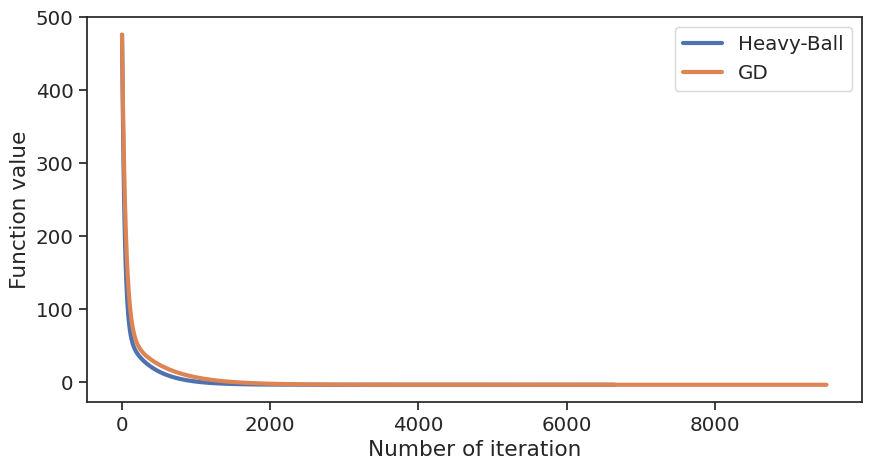

In [403]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

Те же графики в лог-лог шкале

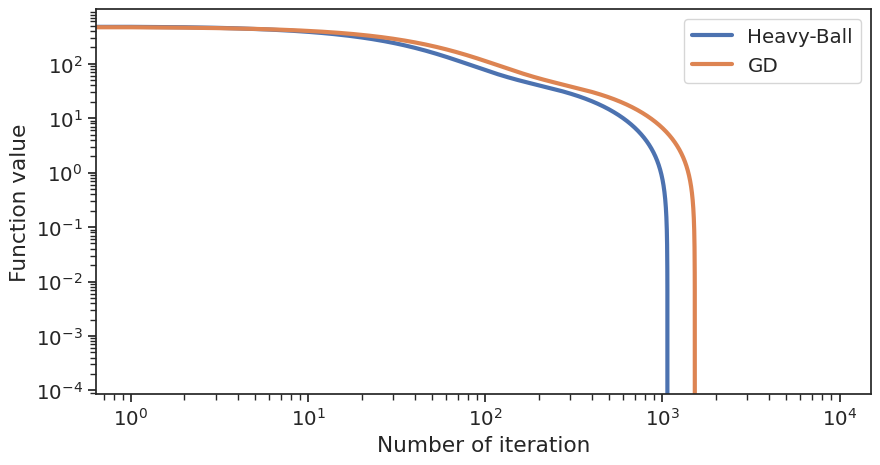

In [404]:
draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Оба метода сходятся примерно за одинаковое количество итераций, при этом Heavy-Ball может вести себя немонотонно

### Nesterov momentum


$$ x_{k+1} = x_k + \beta_k (x_k - x_{k-1}) - \alpha_k \nabla f (x_k + \beta_k (x_k - x_{k-1})) $$

$$ \alpha_k, ~ \beta_k - \text{параметры} $$

In [405]:
def Nesterov_momentum(x0: np.ndarray, A: np.ndarray, b: np.ndarray,
                      N: int, eps: float, y0: Optional[np.ndarray] = None, verbose: bool = False):
    """
    Nesterov method for quadratic functions
    
    :param x0: initial guess of x
    :param A: constant matrix from function f(x)
    :param b: constant vector from function f(x)
    :param N: max number of iterations
    :return: f_vals, x_min, number of iterations
    """
    if verbose:
        logger.setLevel("DEBUG")
    else:
        logger.setLevel("INFO")
    
    eigen_vals = np.linalg.eigvals(A)
    mu = np.min(eigen_vals)  # константа сильной выпуклости
    L = np.max(eigen_vals)  # константа Липшица
    
    n = len(x0)
    x = np.zeros((N, n))
    y = np.zeros((N, n))
    x[0] = x0
    if y0 is None: y[0] = x0

    f_vals = np.zeros(N)
    f_vals[0] = f(x[0], A, b)

    norm_0 = np.linalg.norm(grad_f(x[0], A, b))
    end_iteration = N

    for k in range(N-1):
        # compute params
        alpha_k = 1 / L
        beta_k = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
        # beta_k = k / (k + 3)
        
        # method step
        x[k+1] = y[k] - alpha_k * grad_f(y[k], A, b)
        y[k+1] = x[k+1] + beta_k * (x[k+1] - x[k])
        
        norm_k = np.linalg.norm(grad_f(x[k+1], A, b))
        stop_criteria = ((norm_k**2) / (norm_0**2)) <= eps
        
        f_vals[k] = f(x[k], A, b)
        f_vals[k+1] = f(x[k+1], A, b)
        
        if stop_criteria:
            x_min = x[k+1]
            end_iteration = k+1
            logger.info(f'Nesterov converge at {k+1} iteration, min f(x) = {f_vals[k+1]}')
            logger.debug(f'x_min = {x_min}')
            break
        
    if not stop_criteria:
            x_min = None
            logger.info(f'(!) Nesterov didnt converge, may be need to increase number of iterations N')
            logger.debug(f'last f(x) = {f_vals[k+1]} at x = {x[k+1]}')
            logger.debug(f"current epsilon = {(norm_k**2 / norm_0**2)}")
    
    return f_vals, x_min, end_iteration

#### Сравнение с градиентным спуском

In [406]:
n = 2
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

In [413]:
N = int(1e4)
eps = 1e-10

x0 = sps.uniform(loc=1, scale=10).rvs(n)
x0

array([6.31964412, 6.97615196])

Сравнение

In [414]:
f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)

INFO: Nesterov converge at 32 iteration, min f(x) = -6.639588019328509


In [415]:
f_vals_GD, x, N_iter_GD, alphas = gradient_descent(n, N, alpha, eps, A, b, x0)

INFO: GD converge at 9481 iteration, min f(x) = -6.639587904718195


In [416]:
scipy.optimize.minimize(f, x0, args=(A, b))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -6.63958817959067
        x: [-3.446e+00 -3.750e-01]
      nit: 5
      jac: [ 2.384e-07 -2.384e-07]
 hess_inv: [[ 1.011e+00 -1.644e-03]
            [-1.644e-03  1.002e-01]]
     nfev: 18
     njev: 6

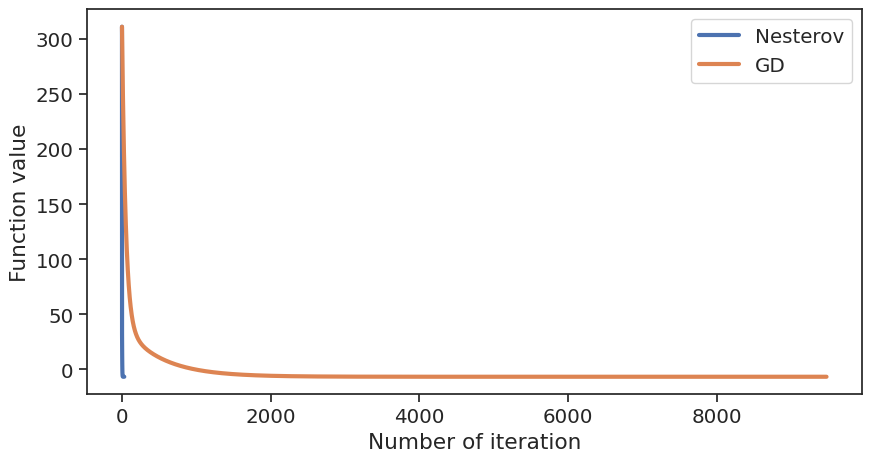

In [417]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

В лог-лог шкале

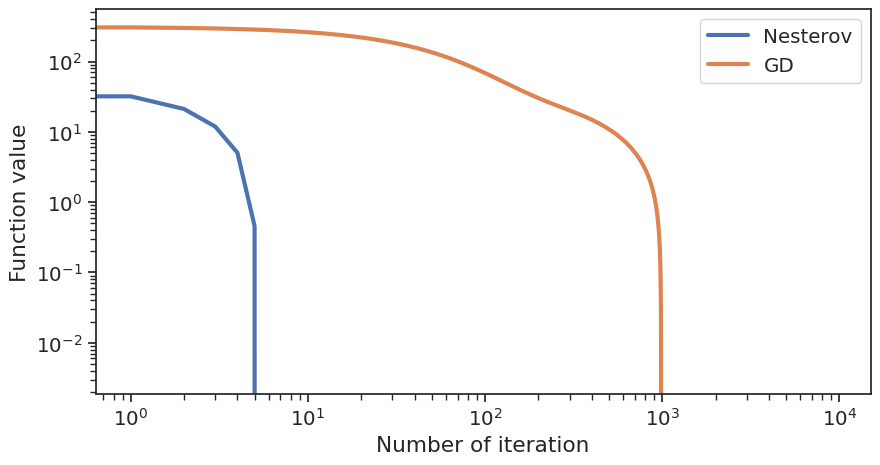

In [418]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
draw_convergence_plot(f_vals_GD, N_iter_GD, label='GD')

plt.yscale('log')
plt.xscale('log')

Метод Нестерова сходится в среднем в 2-10 раз быстрее чем градиентный спуск

### Генерация 9 матриц с разными числами обусловленности

In [419]:
n_list = [2, 10, 1000]
cond_num_list = [1, 100, 1000]

A_list = []
b_list = []

for n in n_list:
    for cond_num in cond_num_list:        
        A, b = quadratic_func_params(n, cond_num)
        A_list.append(A)
        b_list.append(b)

#### Разные начальные точки

Начальная точка 1

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -6.3043136142522265
INFO: HB converge at 8050 iteration, min f(x) = -6.304313609316826


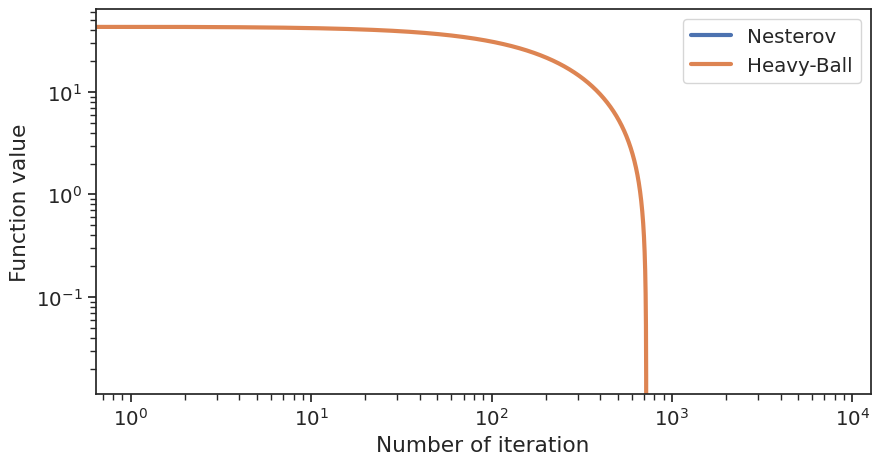

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 97 iteration, min f(x) = -0.7319952652986799
INFO: HB converge at 5439 iteration, min f(x) = -0.7319947047704023


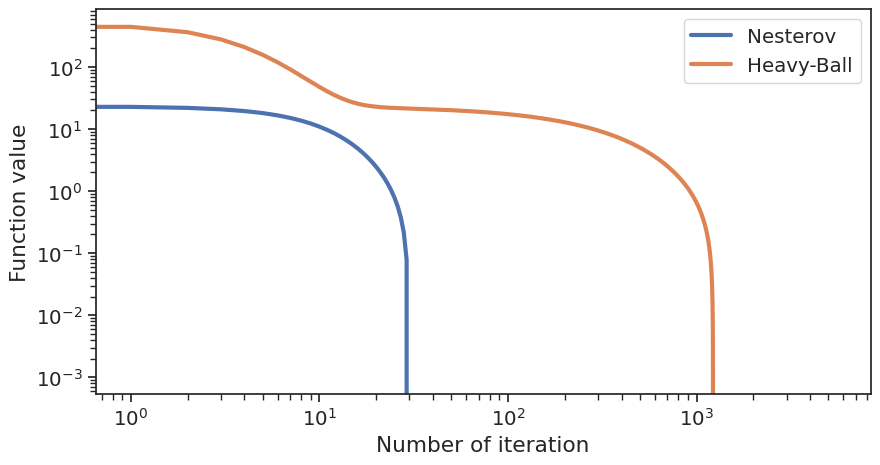

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 213 iteration, min f(x) = -7.8635489435632975
INFO: HB converge at 3342 iteration, min f(x) = -7.86348406609134


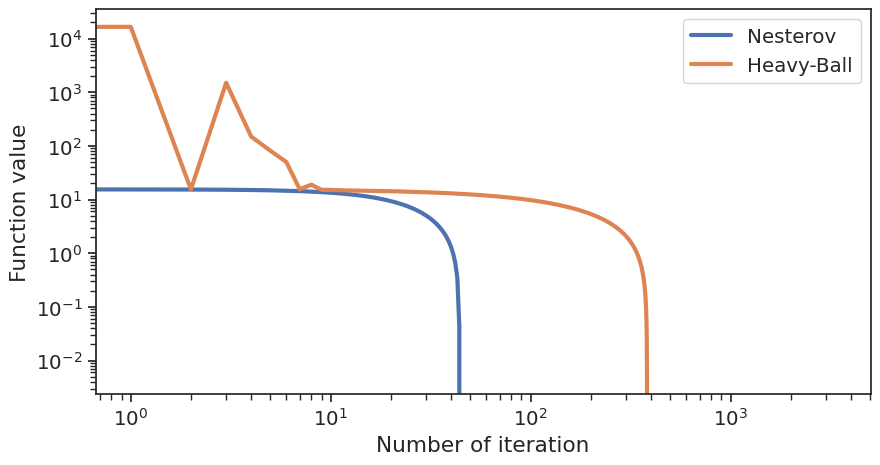

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -28.41098596652309
INFO: HB converge at 7471 iteration, min f(x) = -28.410985949505033


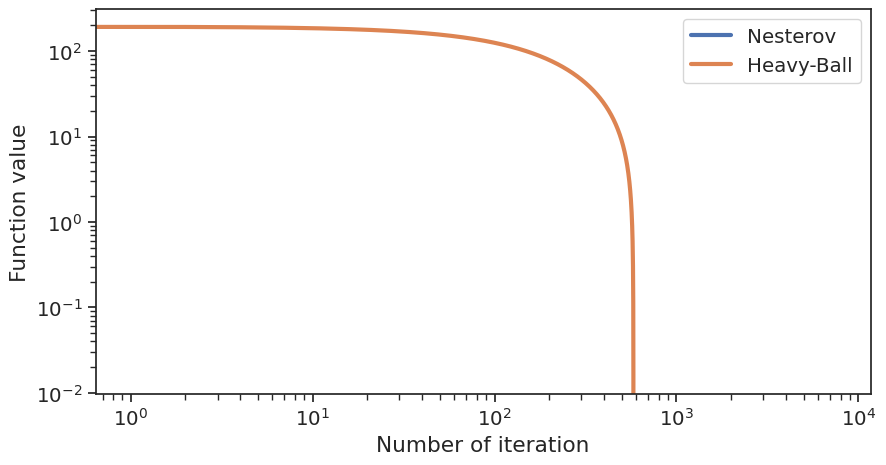

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 88 iteration, min f(x) = -6.7612626876109525
INFO: HB converge at 4885 iteration, min f(x) = -6.761262569259447


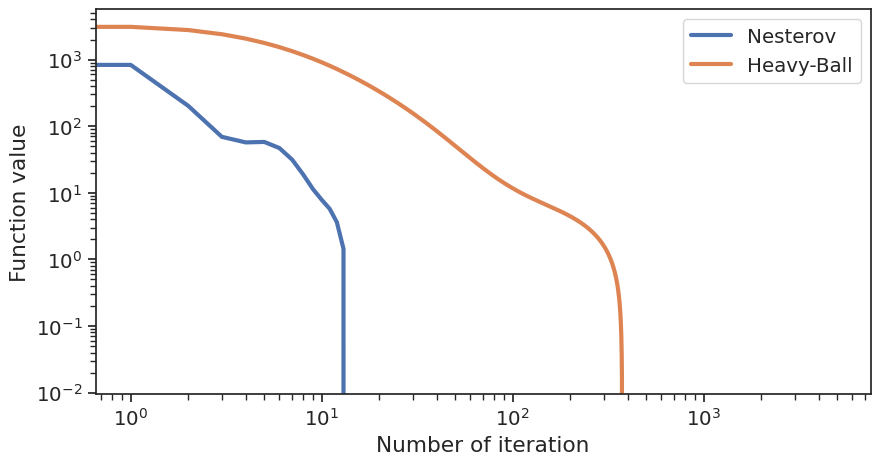

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 204 iteration, min f(x) = -7.13582194582707
INFO: HB converge at 3173 iteration, min f(x) = -7.135753414611376


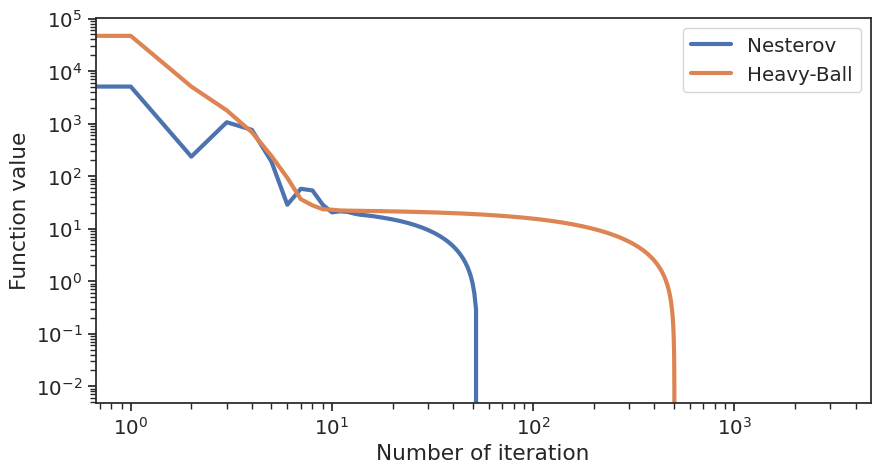

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -3047.354301298094
INFO: HB converge at 6857 iteration, min f(x) = -3047.3542985891145


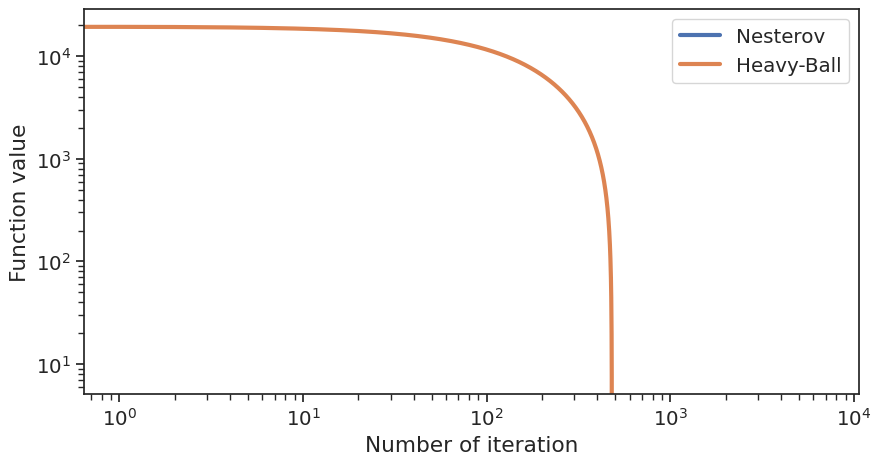

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 68 iteration, min f(x) = -183.48512724070756
INFO: HB converge at 3519 iteration, min f(x) = -183.48469168470842


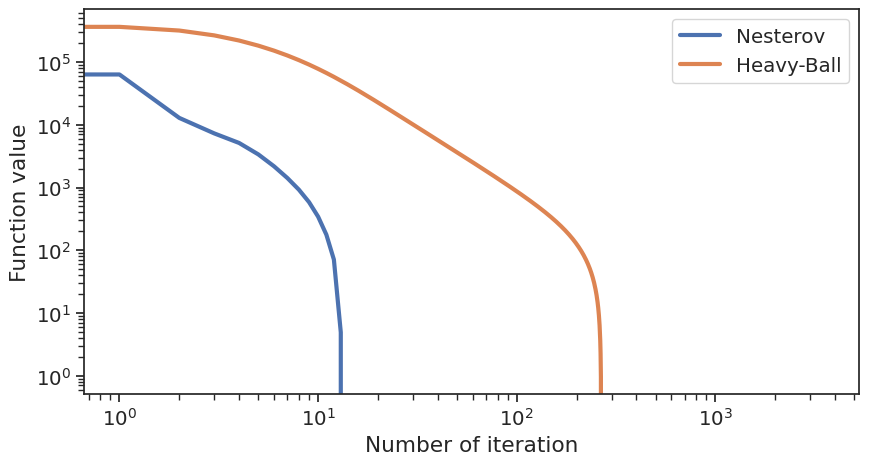

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 149 iteration, min f(x) = -32.858648018574755
INFO: HB converge at 1376 iteration, min f(x) = -32.66245439649508


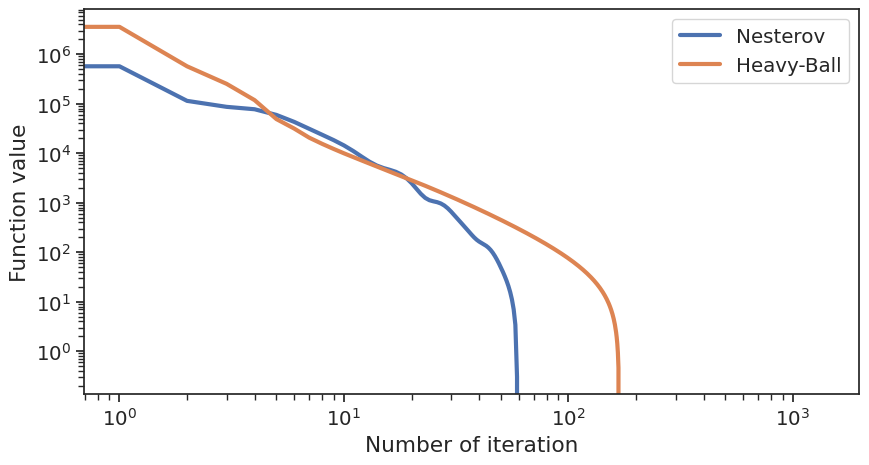

In [422]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
            
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Начальная точка 2

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -6.304313614252225
INFO: HB converge at 8050 iteration, min f(x) = -6.304313008448195


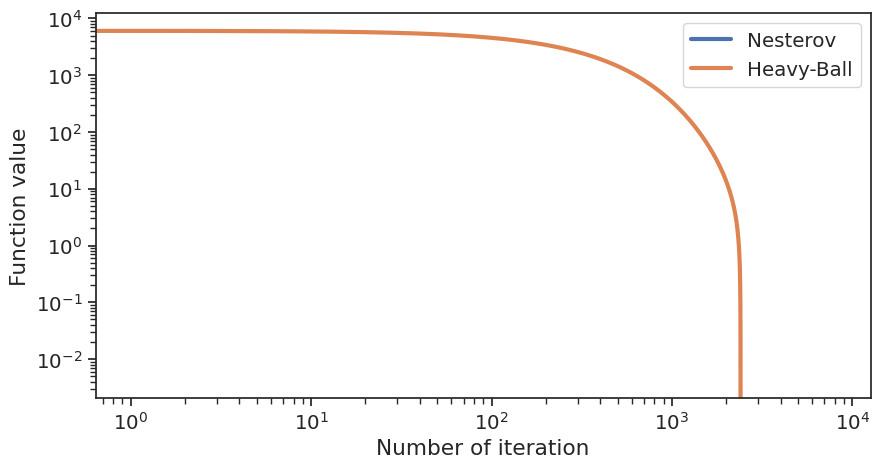

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 80 iteration, min f(x) = -0.7274616157783823
INFO: HB converge at 4353 iteration, min f(x) = -0.727399287336876


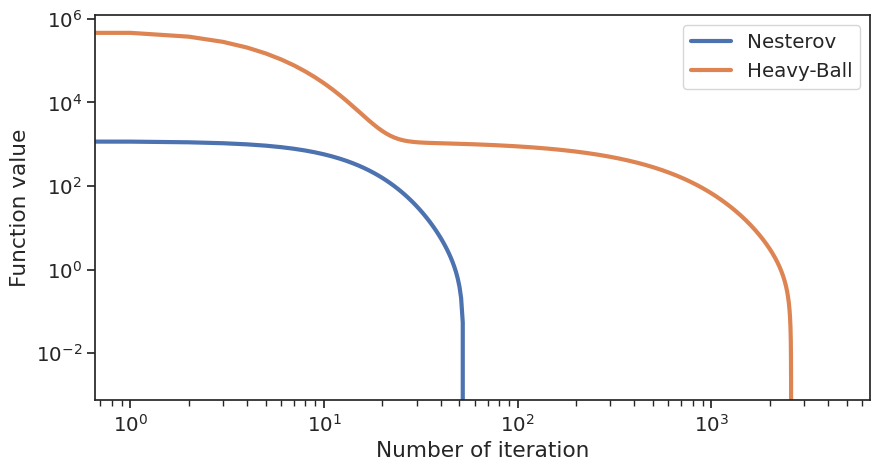

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 233 iteration, min f(x) = -7.755558238135494
INFO: HB converge at 3744 iteration, min f(x) = -7.753555257974326


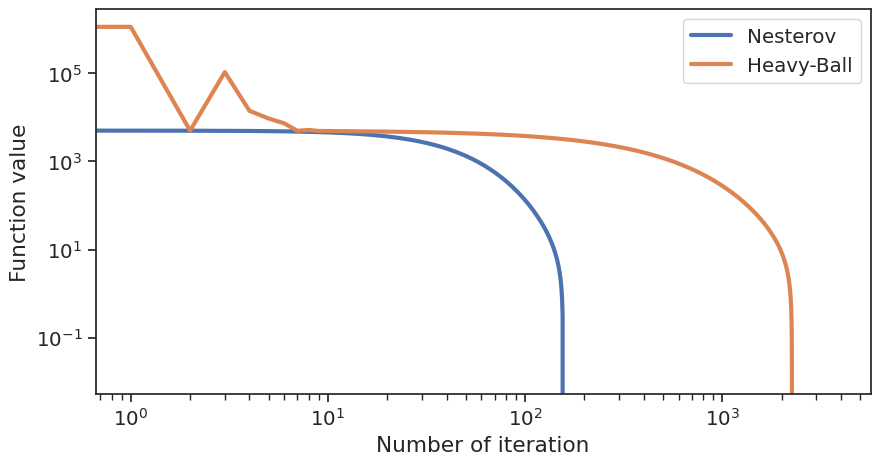

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -28.410983773793482
INFO: HB converge at 7484 iteration, min f(x) = -28.410980352038482


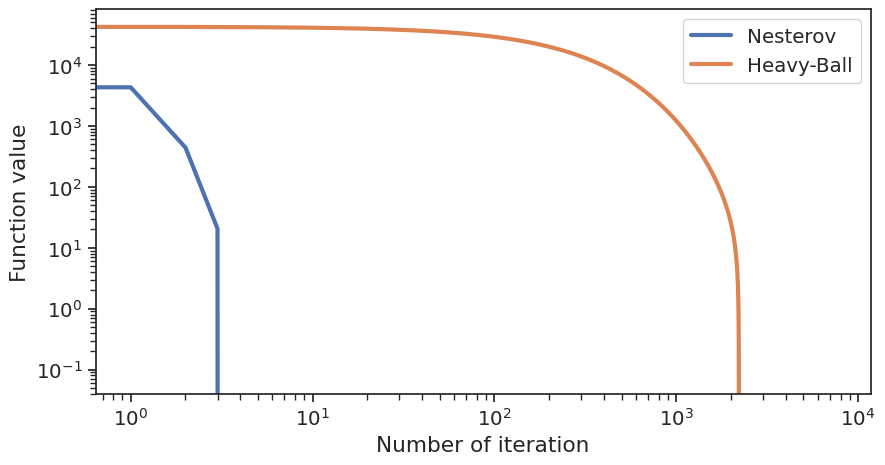

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 85 iteration, min f(x) = -6.7538768665612565
INFO: HB converge at 4638 iteration, min f(x) = -6.752732525152687


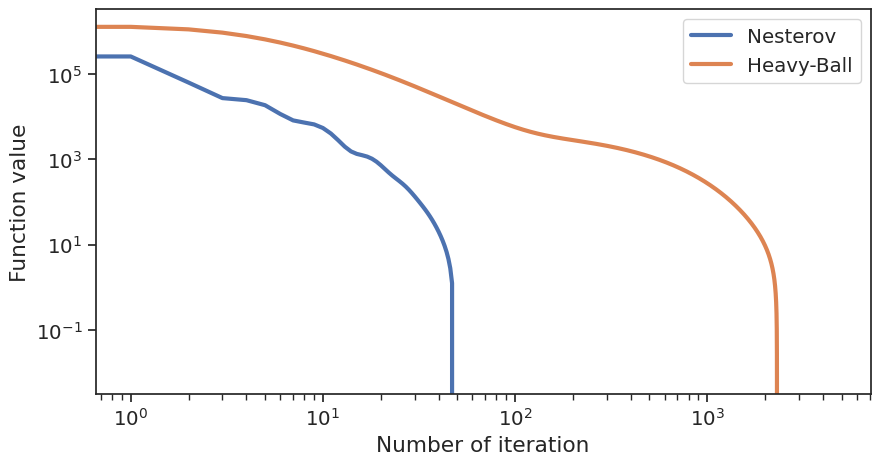

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 192 iteration, min f(x) = -5.831442318715329
INFO: HB converge at 2947 iteration, min f(x) = -5.831414733610259


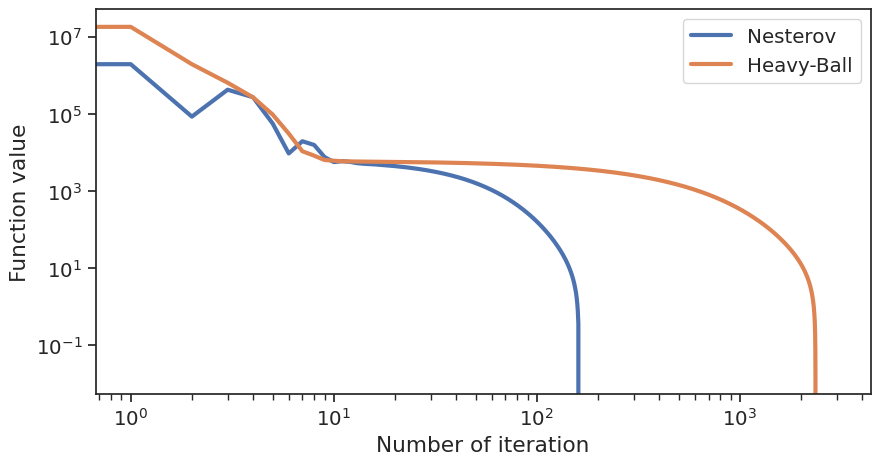

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 10 iteration, min f(x) = -3047.354237234581
INFO: HB converge at 6778 iteration, min f(x) = -3047.3537924200045


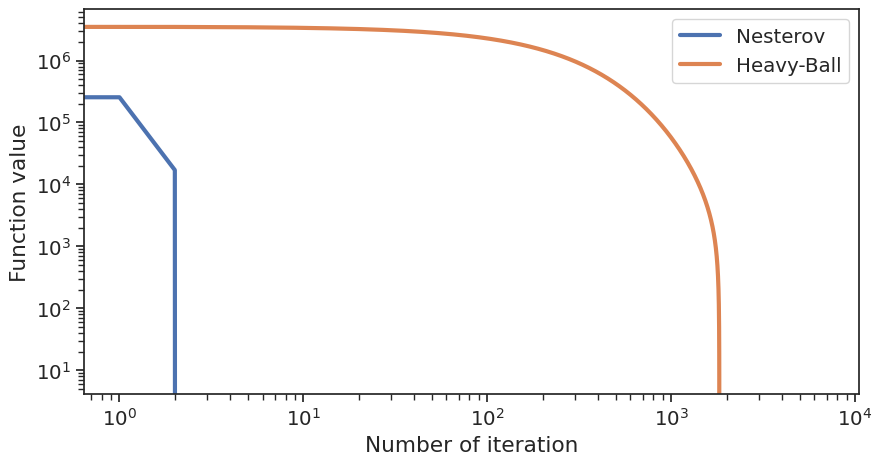

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 63 iteration, min f(x) = -183.05819315461278
INFO: HB converge at 3116 iteration, min f(x) = -182.7872271699615


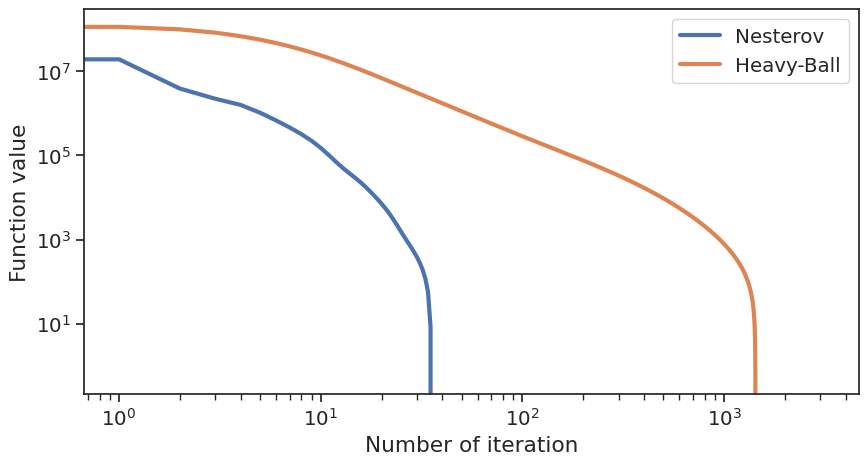

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 146 iteration, min f(x) = -25.500128978667526
INFO: HB converge at 861 iteration, min f(x) = 38.411810996355385


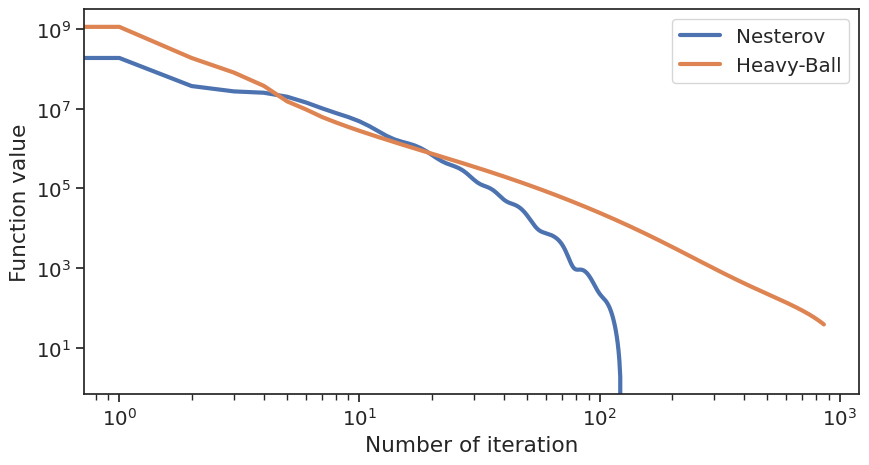

In [423]:
N = int(1e4)
eps = 1e-10

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=10, scale=100).rvs(n, random_state=32)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

#### Разная точность для остановки eps

1) eps = $10^{-5}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -6.3043136142522265
INFO: HB converge at 4026 iteration, min f(x) = -6.3038203182705175


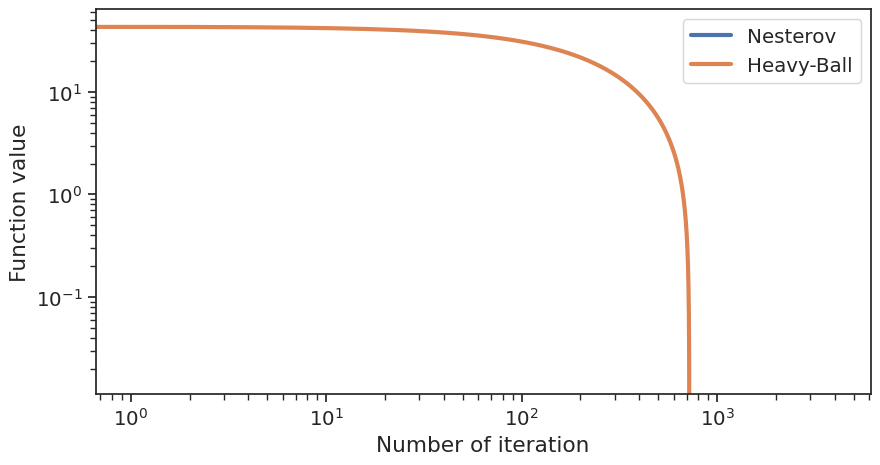

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 34 iteration, min f(x) = -0.3724037496043305
INFO: HB converge at 1415 iteration, min f(x) = -0.31120522827542463


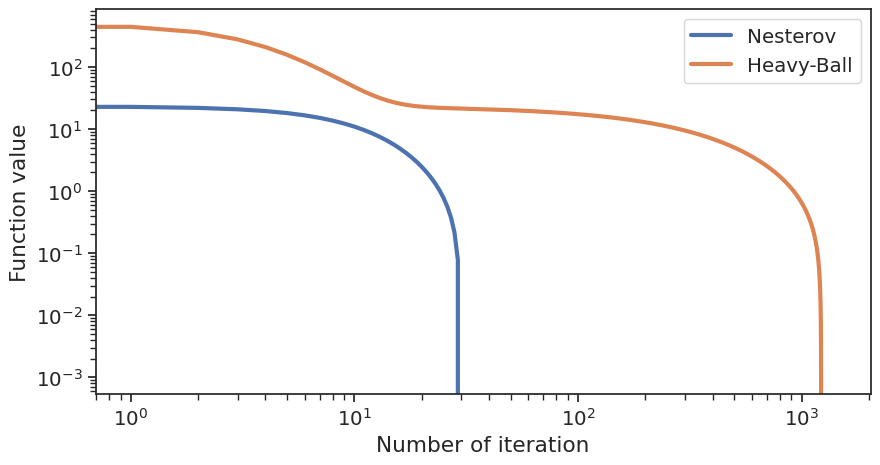

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 1 iteration, min f(x) = 15.467625697842605
INFO: HB converge at 2 iteration, min f(x) = 15.467625697842605


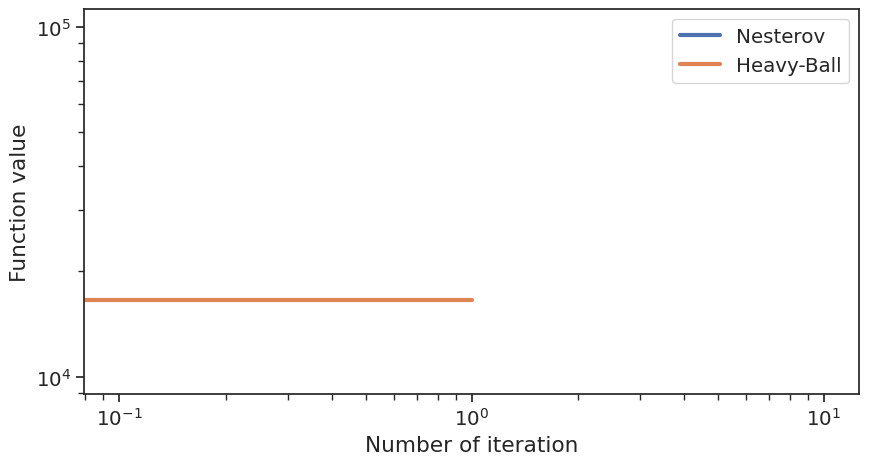

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 5 iteration, min f(x) = -28.40889015901492
INFO: HB converge at 3550 iteration, min f(x) = -28.408244357576162


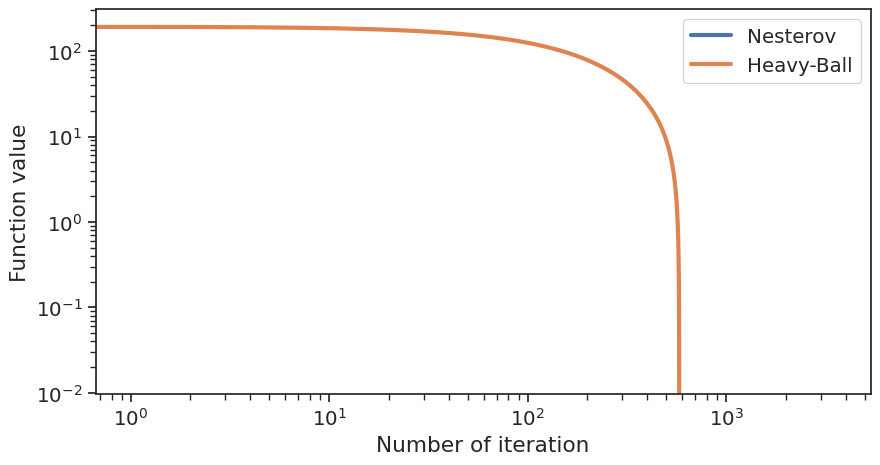

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 24 iteration, min f(x) = -5.313306547249082
INFO: HB converge at 861 iteration, min f(x) = -5.083285013707669


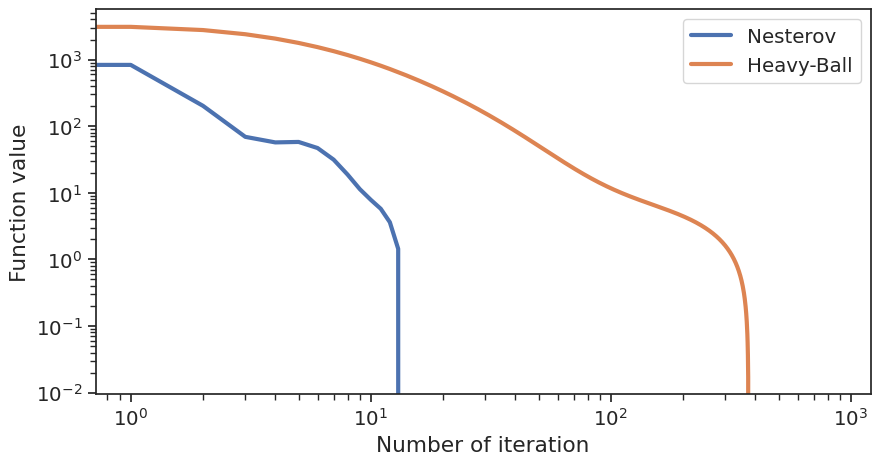

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 10 iteration, min f(x) = 20.432421244351225
INFO: HB converge at 11 iteration, min f(x) = 22.203791335178195


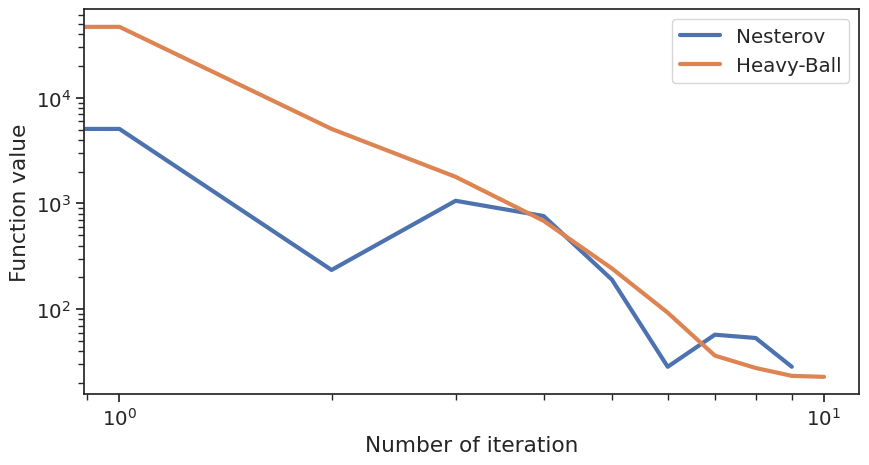

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 5 iteration, min f(x) = -3047.2578957388905
INFO: HB converge at 3134 iteration, min f(x) = -3047.0514137181976


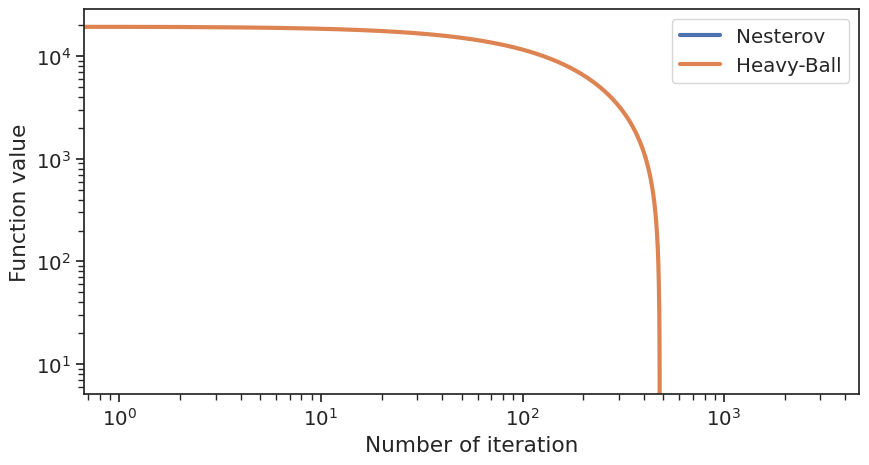

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 19 iteration, min f(x) = -142.9274688017236
INFO: HB converge at 339 iteration, min f(x) = -69.74791995730058


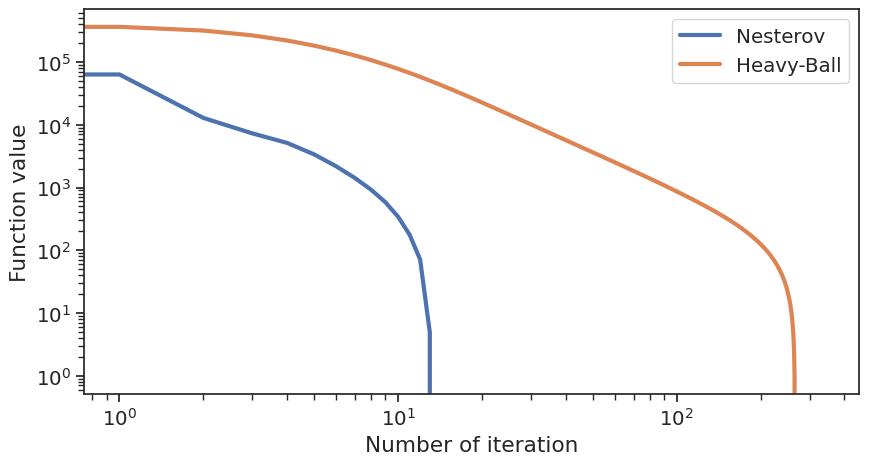

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 32 iteration, min f(x) = 476.75776097576414
INFO: HB converge at 33 iteration, min f(x) = 1088.7659093576535


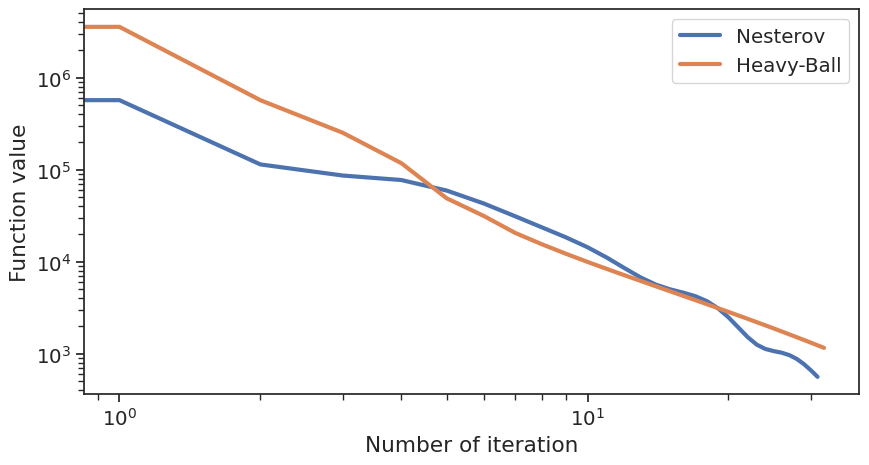

In [424]:
N = int(1e4)
eps = 1e-5

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

2) eps = $10^{-8}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -6.3043136142522265
INFO: HB converge at 6441 iteration, min f(x) = -6.304313121656123


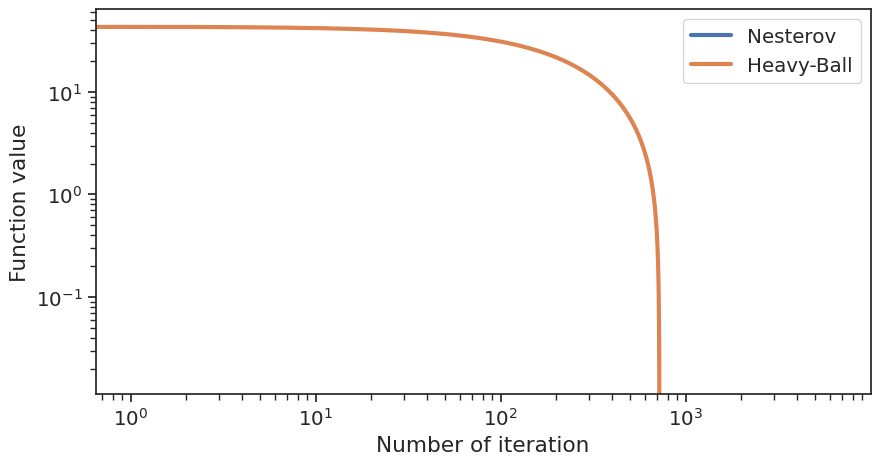

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 72 iteration, min f(x) = -0.7315830358637577
INFO: HB converge at 3830 iteration, min f(x) = -0.7315787181155885


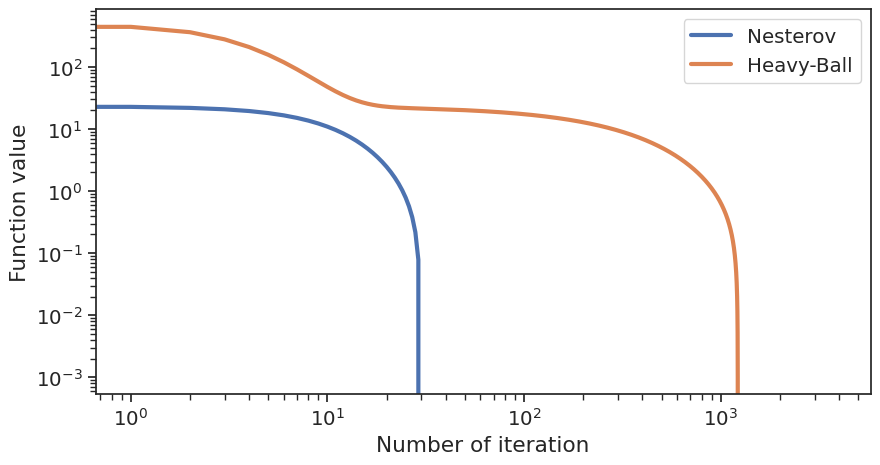

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 128 iteration, min f(x) = -7.705756806984283
INFO: HB converge at 1732 iteration, min f(x) = -7.6997058494687165


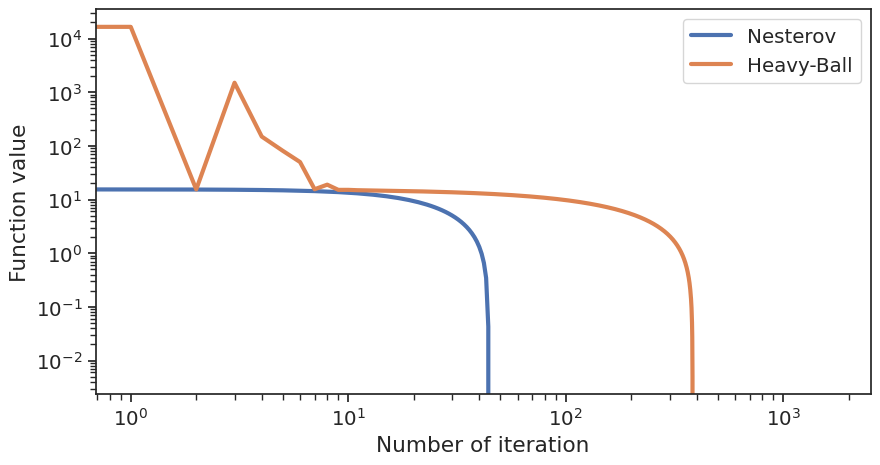

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 8 iteration, min f(x) = -28.410984477330754
INFO: HB converge at 5889 iteration, min f(x) = -28.41098317873939


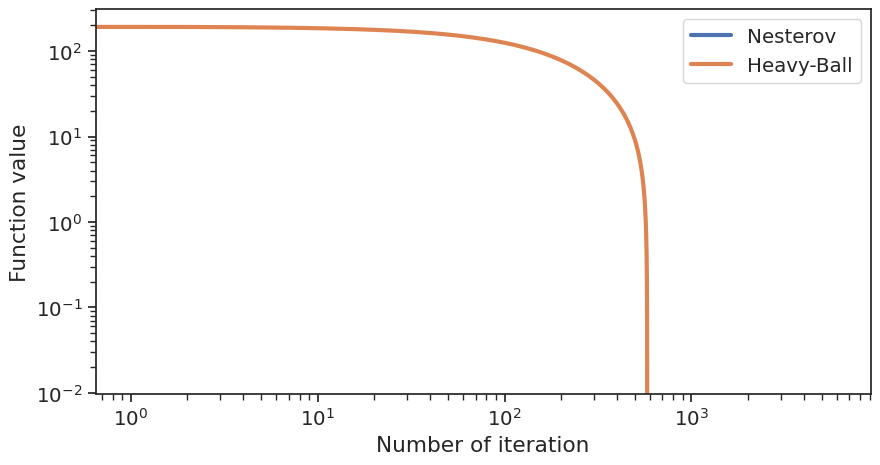

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 64 iteration, min f(x) = -6.759785457700833
INFO: HB converge at 3275 iteration, min f(x) = -6.759598943165436


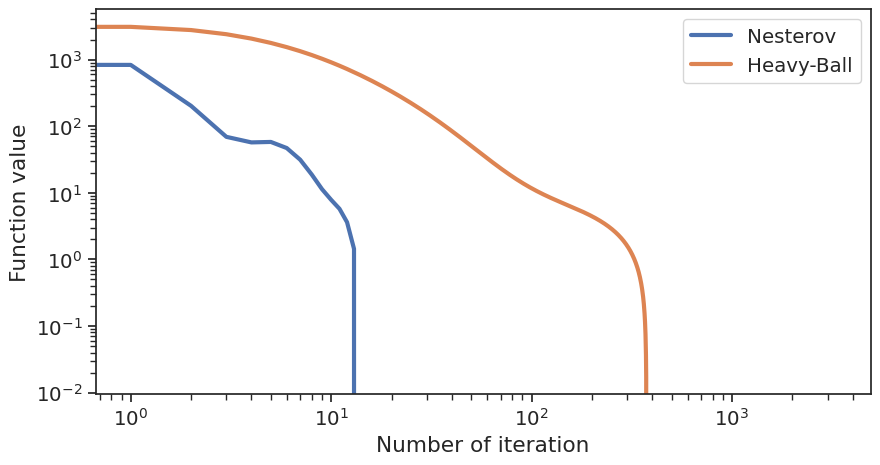

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 118 iteration, min f(x) = -6.797233604168826
INFO: HB converge at 1563 iteration, min f(x) = -6.7946652662535545


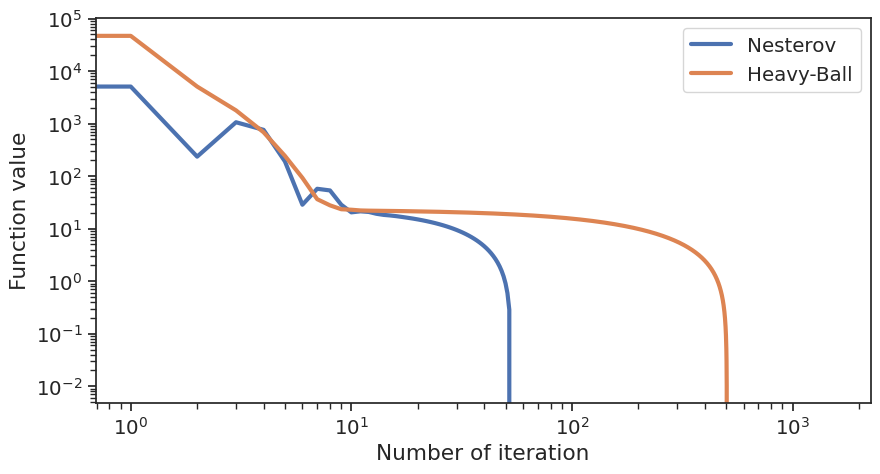

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 8 iteration, min f(x) = -3047.354239011521
INFO: HB converge at 5342 iteration, min f(x) = -3047.3539856350444


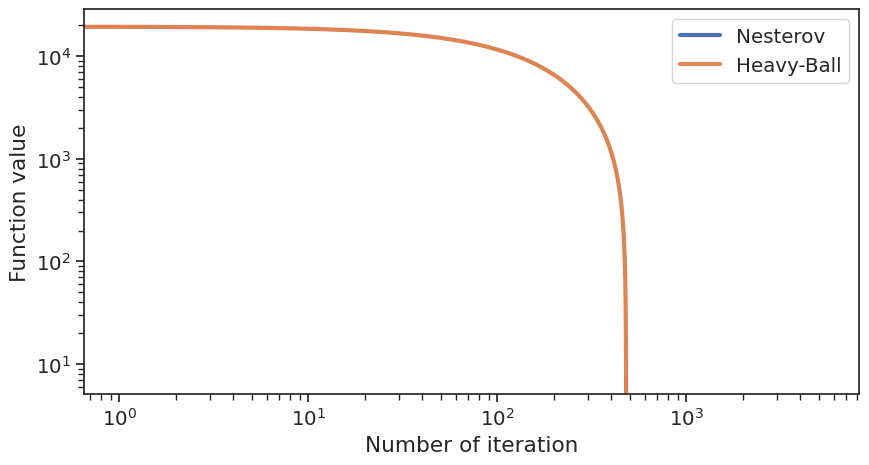

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 46 iteration, min f(x) = -183.34951341045593
INFO: HB converge at 2012 iteration, min f(x) = -183.26788659083016


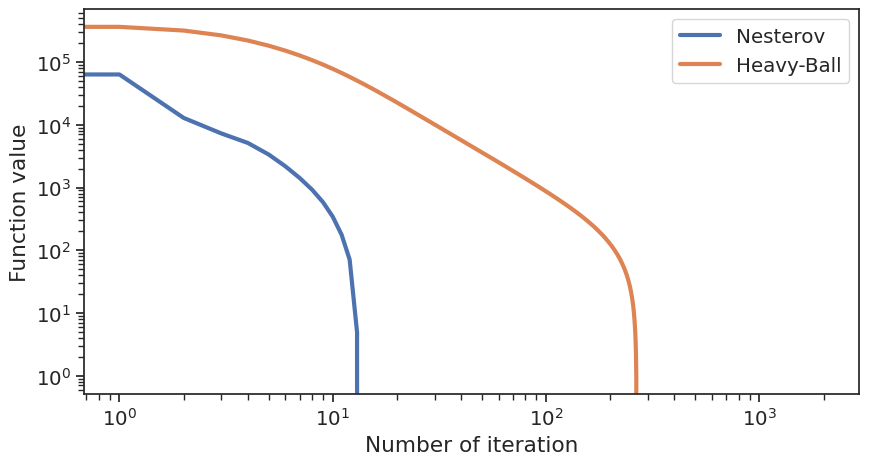

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 95 iteration, min f(x) = -31.139028010230373
INFO: HB converge at 291 iteration, min f(x) = -23.54205194094858


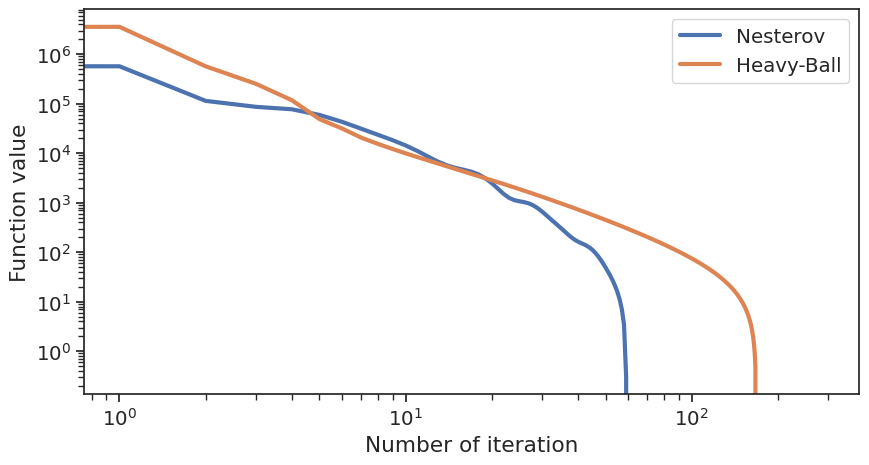

In [425]:
N = int(1e4)
eps = 1e-8

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

3) eps = $10^{-12}$

INFO: n = 2, condition number = 1
INFO: Nesterov converge at 1 iteration, min f(x) = -6.3043136142522265
INFO: HB converge at 9660 iteration, min f(x) = -6.304313614202919


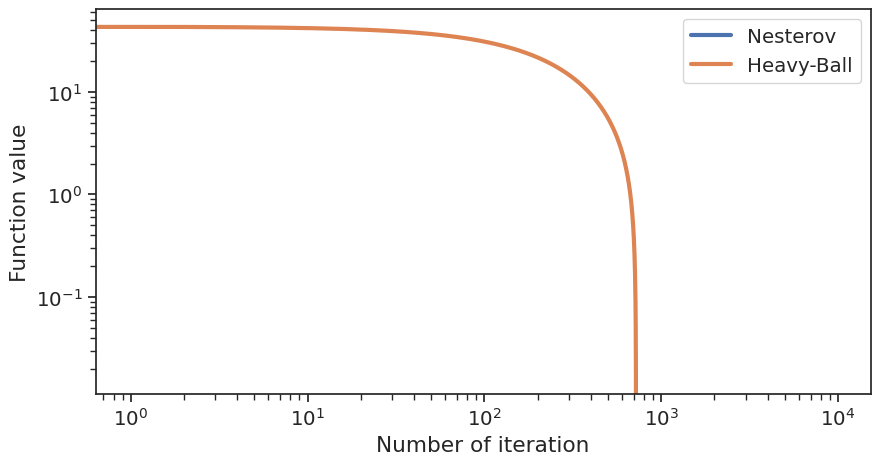

INFO: n = 2, condition number = 100
INFO: Nesterov converge at 121 iteration, min f(x) = -0.7319988799836771
INFO: HB converge at 7049 iteration, min f(x) = -0.7319988727288073


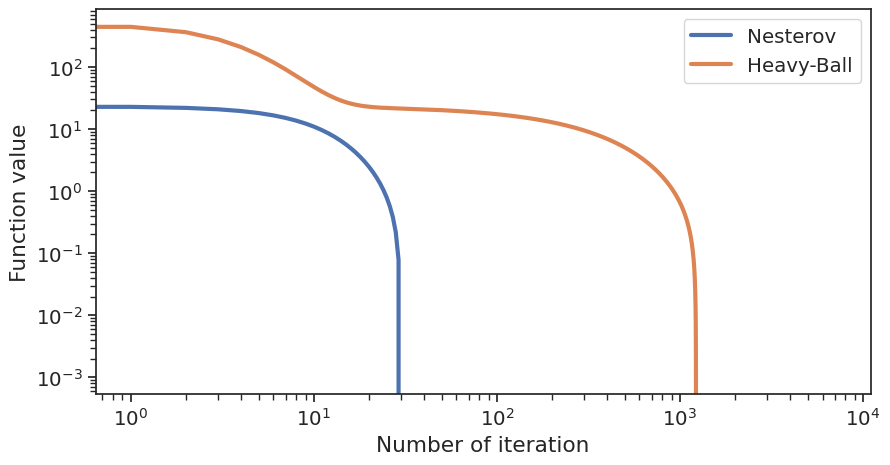

INFO: n = 2, condition number = 1000
INFO: Nesterov converge at 293 iteration, min f(x) = -7.8651204534022705
INFO: HB converge at 4951 iteration, min f(x) = -7.865120251484235


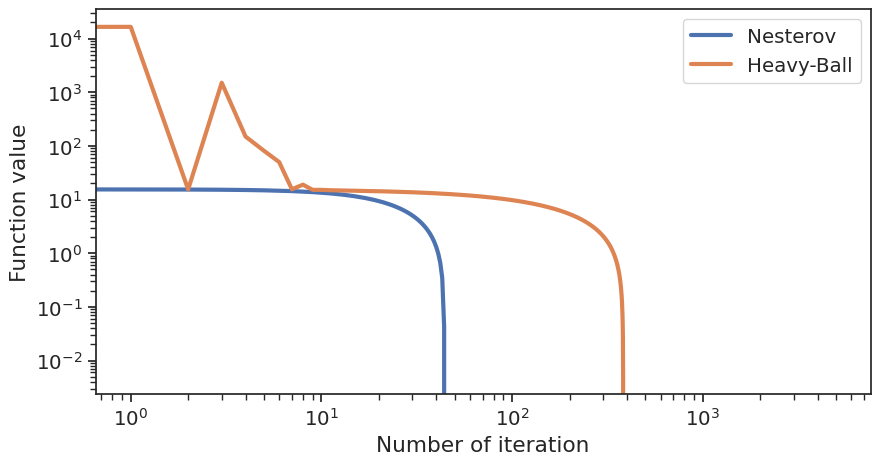

INFO: n = 10, condition number = 1
INFO: Nesterov converge at 12 iteration, min f(x) = -28.410985977631583
INFO: HB converge at 9063 iteration, min f(x) = -28.41098597742669


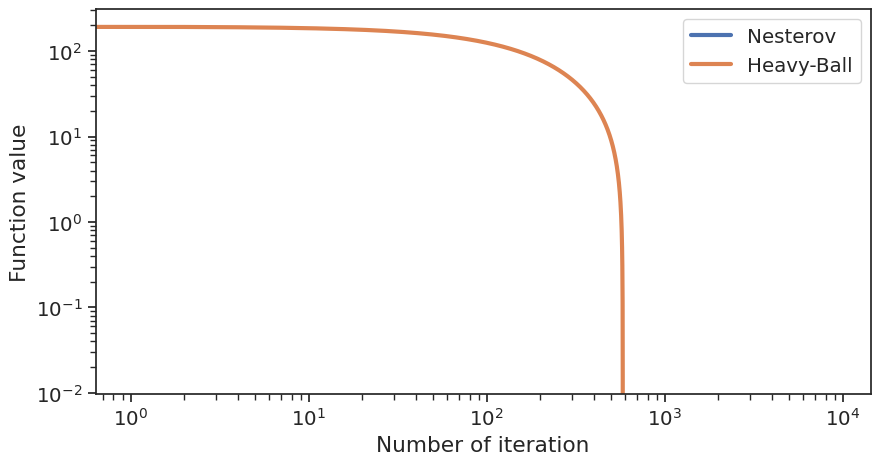

INFO: n = 10, condition number = 100
INFO: Nesterov converge at 112 iteration, min f(x) = -6.761279193127974
INFO: HB converge at 6495 iteration, min f(x) = -6.761279189781221


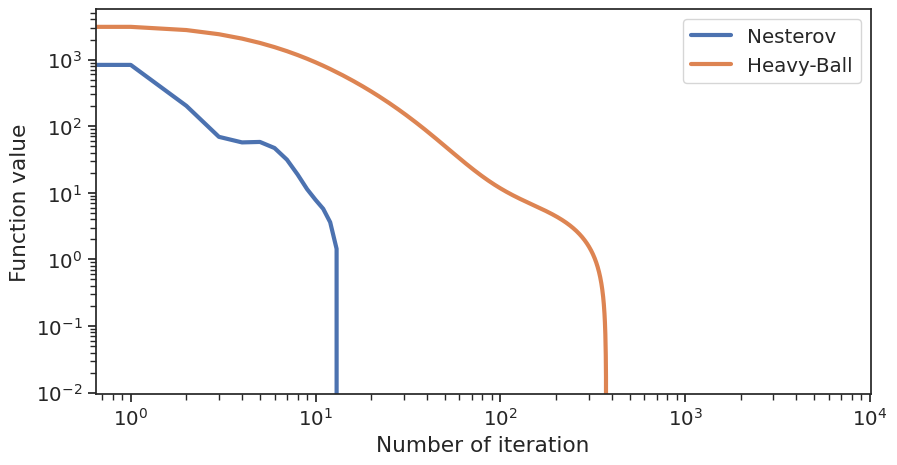

INFO: n = 10, condition number = 1000
INFO: Nesterov converge at 285 iteration, min f(x) = -7.139162041219294
INFO: HB converge at 4783 iteration, min f(x) = -7.139161069141917


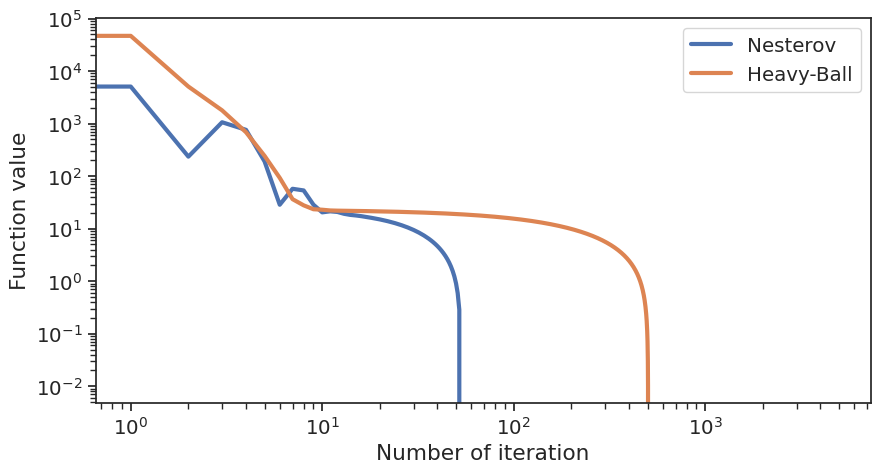

INFO: n = 1000, condition number = 1
INFO: Nesterov converge at 12 iteration, min f(x) = -3047.3543017857364
INFO: HB converge at 8390 iteration, min f(x) = -3047.3543017573684


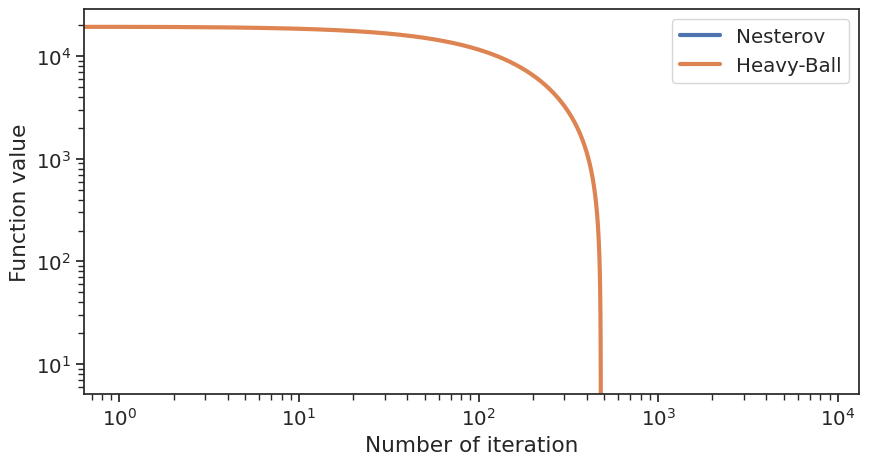

INFO: n = 1000, condition number = 100
INFO: Nesterov converge at 92 iteration, min f(x) = -183.48698514961225
INFO: HB converge at 5085 iteration, min f(x) = -183.48698108710562


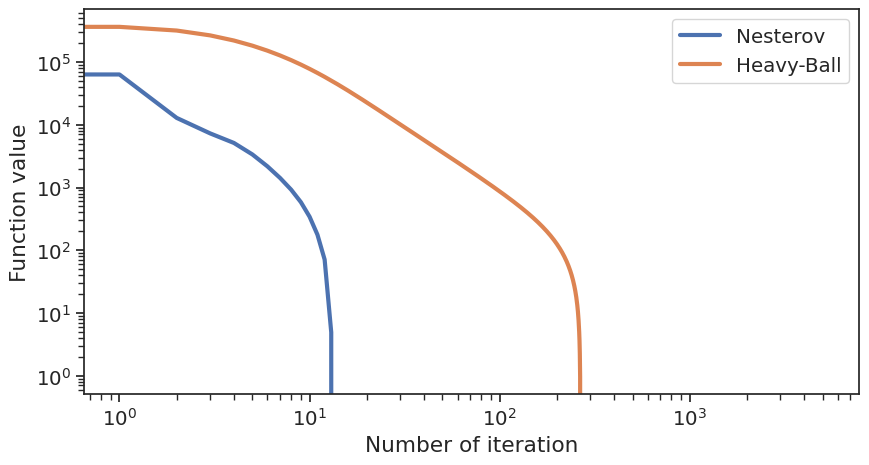

INFO: n = 1000, condition number = 1000
INFO: Nesterov converge at 213 iteration, min f(x) = -32.90235045736504
INFO: HB converge at 2985 iteration, min f(x) = -32.90094707636503


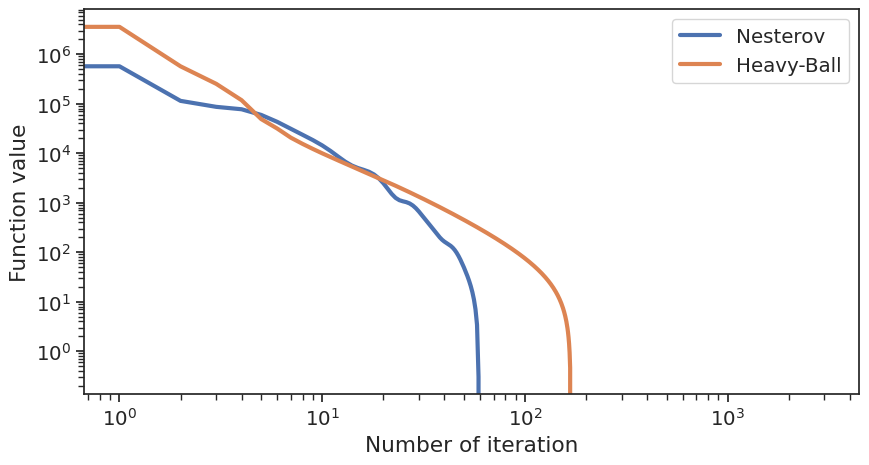

In [426]:
N = int(1e4)
eps = 1e-12

alpha = 0.001
beta = 0.3

for A, b in zip(A_list, b_list):
            
    n = len(b)
    cond_num = int(np.max(A))
    logger.info(f"n = {n}, condition number = {cond_num}")
    
    x0 = sps.uniform(loc=1, scale=5).rvs(n, random_state=42)
    
    f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps)
    f_vals_HB, x_min, N_iter_HB = heavy_ball_method(x0, A, b, N, alpha, beta, eps)
    
    
    draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')
    draw_convergence_plot(f_vals_HB, N_iter_HB, label='Heavy-Ball')
    plt.xscale("log"); plt.yscale("log")
    plt.show()

Для плохообусловленных задач следует повышать требуемую точность.

При `n = 1000, cond_num = 1000` результаты работы метода Нестерова и метода тяжелого шарика совпадают только при высокой точности `eps = 1e-12`

### Разные начальные условия

In [230]:
n = 10
cond_num = 10

A, b = quadratic_func_params(n, cond_num)

$$ x_0 = y_0 = 0_n $$

In [231]:
x0 = np.zeros(n)
y0 = np.zeros(n)

In [232]:
eps = 1e-8

f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps, y0=y0)

INFO: Nesterov converge at 22 iteration, min f(x) = -10.25150985264224


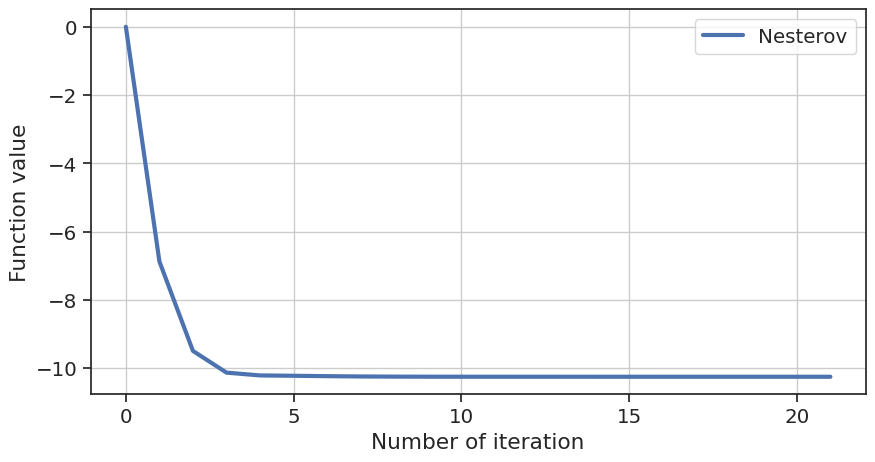

In [234]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

$$ x_0 = 0_n, ~ y_0 = 1_n $$

In [235]:
x0 = np.zeros(n)
y0 = np.ones(n)

In [236]:
eps = 1e-8

f_vals_Nest, x_min, N_iter_Nest = Nesterov_momentum(x0, A, b, N, eps, y0=y0)

INFO: Nesterov converge at 22 iteration, min f(x) = -10.25150985264224


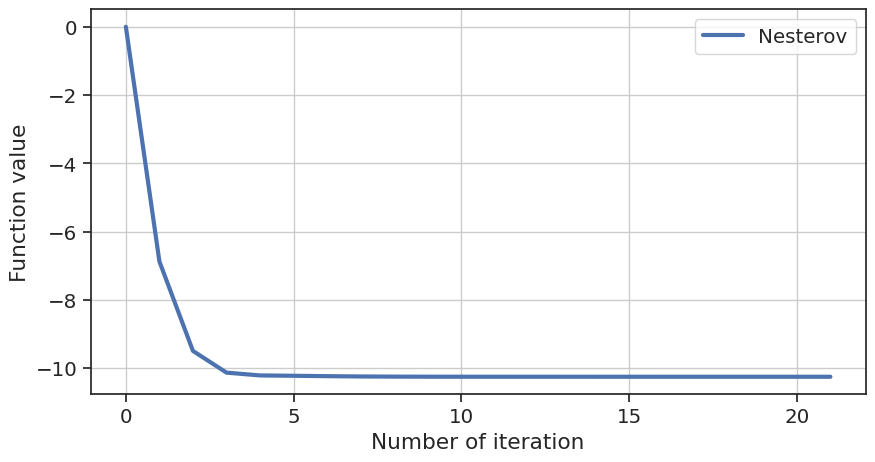

In [237]:
draw_convergence_plot(f_vals_Nest, N_iter_Nest, label='Nesterov')

Метод Нестерова работает одинаково для двух данных начальных условий

# End